# Лабораторная работа 5. ОБУЧЕНИЕ БЕЗ УЧИТЕЛЯ. ЗАДАЧА КЛАСТЕРИЗАЦИИ

# Загрузка необходимых бибилиотек

In [33]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from itertools import product

# Загрузка и подготовка данных. 

## Сгенерировать 3 датасета с использованием функции make_classification и 2 датасета с использованием функции make_blobs. Данные необходимо сгенерировать так, чтобы на них можно было получить хорошее качество кластеризации. Количество кластеров должно быть различным и не менее трёх 

In [8]:
# 1. Создаем 3 датасета с make_classification (исправленные параметры)
# Датасет 1 (3 класса)
data1, data_y1 = make_classification(n_samples=300, n_classes=3, n_features=2,
                                   n_informative=2, n_redundant=0,
                                   n_clusters_per_class=1, flip_y=0.01, 
                                   random_state=42)

# Датасет 2 (4 класса)
data2, data_y2 = make_classification(n_samples=400, n_classes=4, n_features=2,
                                   n_informative=2, n_redundant=0,
                                   n_clusters_per_class=1, flip_y=0.01,
                                   random_state=110)

# Датасет 3 (5 классов) - для 5 классов нужно больше признаков
data3, data_y3 = make_classification(n_samples=500, n_classes=5, n_features=3,  # Изменили на 3 признака
                                   n_informative=3, n_redundant=0,
                                   n_clusters_per_class=1, flip_y=0.01,
                                   random_state=7)

# 2. Создаем 2 датасета с make_blobs
# Датасет 4 (3 кластера)
data4, data_y4 = make_blobs(n_samples=300, centers=3, n_features=2,
                          cluster_std=0.8, random_state=42)

# Датасет 5 (5 кластеров)
data5, data_y5 = make_blobs(n_samples=400, centers=5, n_features=2,
                          cluster_std=0.6, random_state=110)

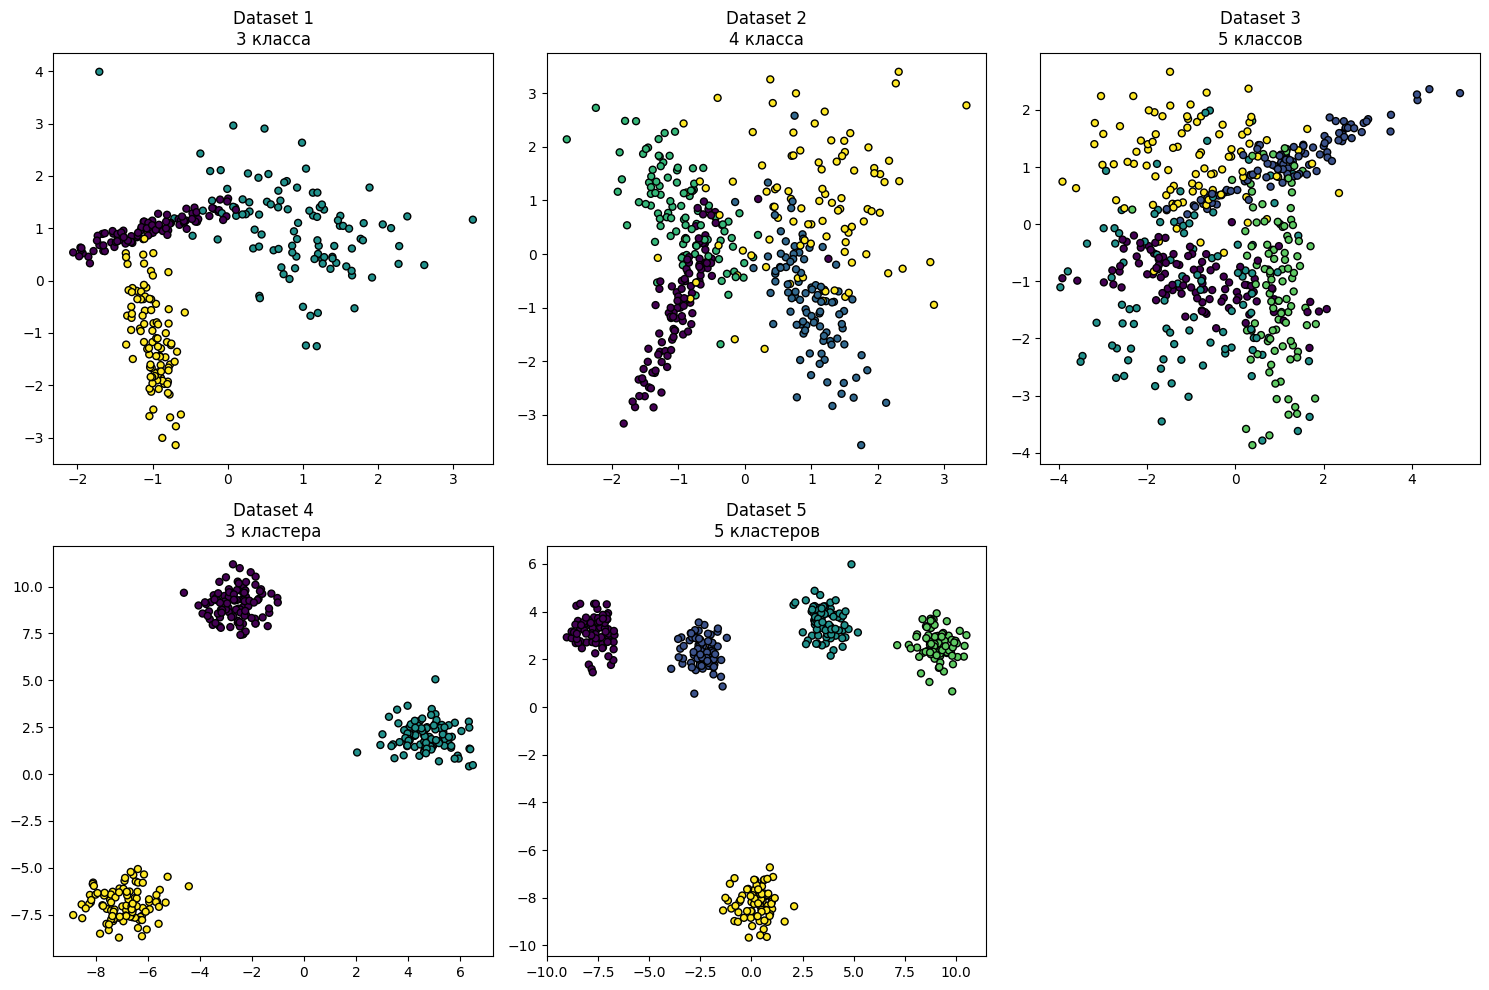

In [12]:
# Визуализация с метками. Как видит классификатор
plt.figure(figsize=(15, 10))
titles = ["3 класса", "4 класса", "5 классов", "3 кластера", "5 кластеров"]
for i, (data, y, title) in enumerate(zip([data1, data2, data3, data4, data5],
                                       [data_y1, data_y2, data_y3, data_y4, data_y5],
                                       titles), 1):
    plt.subplot(2, 3, i)
    plt.scatter(data[:, 0], data[:, 1], c=y, marker="o", s=25, edgecolor="k")
    plt.title(f"Dataset {i}\n{title}")

plt.tight_layout()
plt.show()

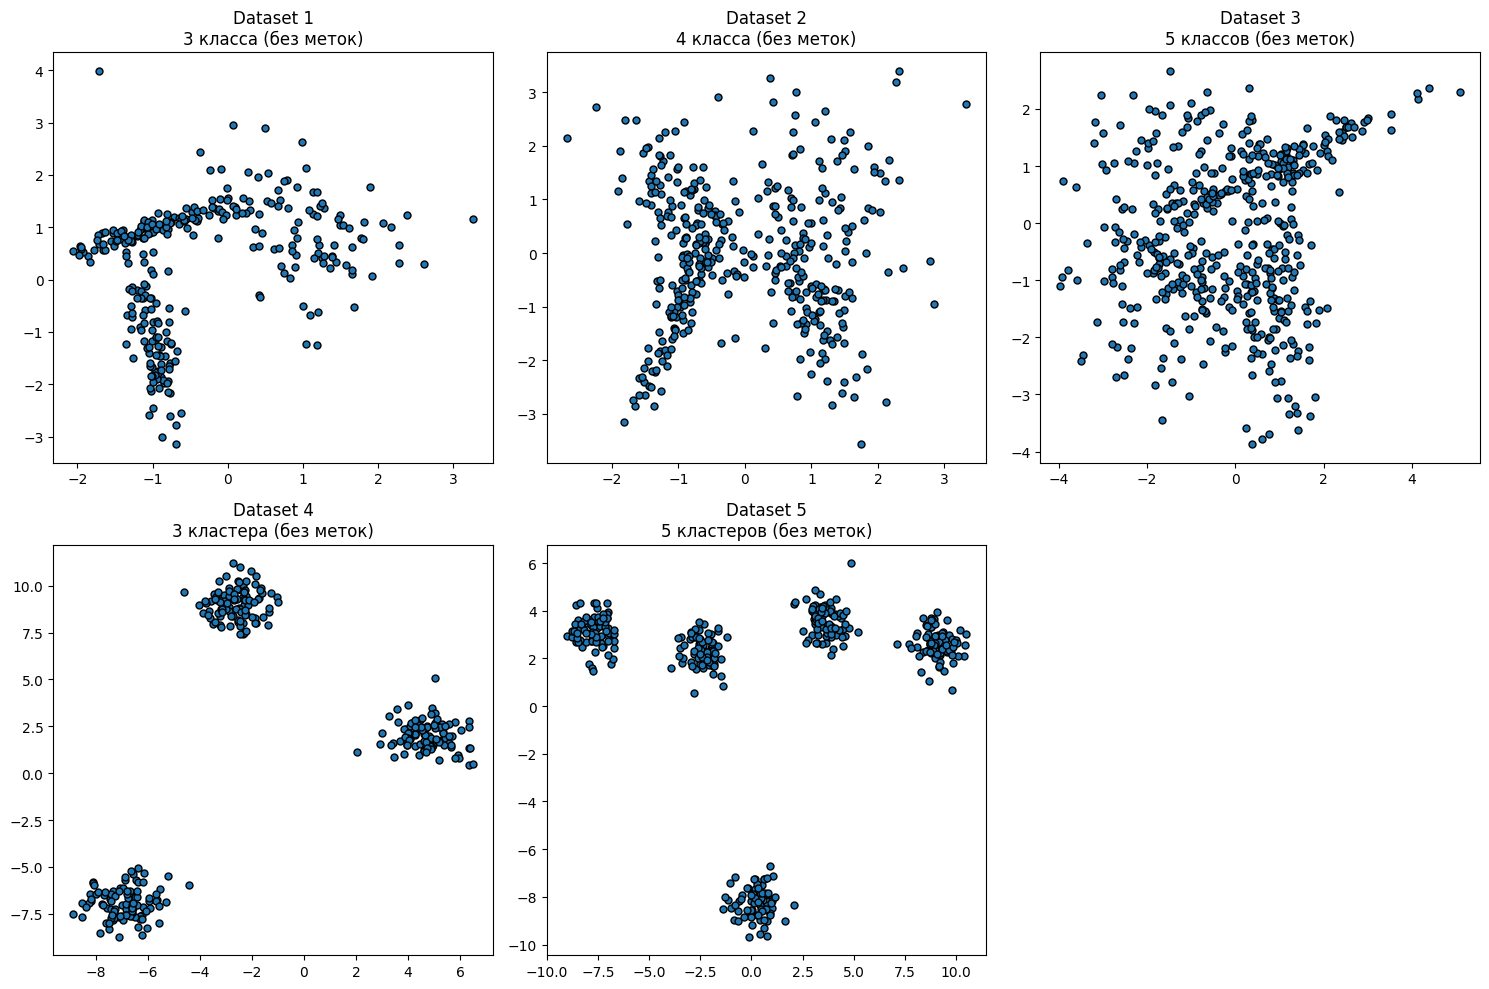

In [11]:
# Визуализация без меток. Как видит кластеризатор
plt.figure(figsize=(15, 10))
for i, (data, title) in enumerate(zip([data1, data2, data3, data4, data5], titles), 1):
    plt.subplot(2, 3, i)
    plt.scatter(data[:, 0], data[:, 1], marker="o", s=25, edgecolor="k")
    plt.title(f"Dataset {i}\n{title} (без меток)")

plt.tight_layout()
plt.show()

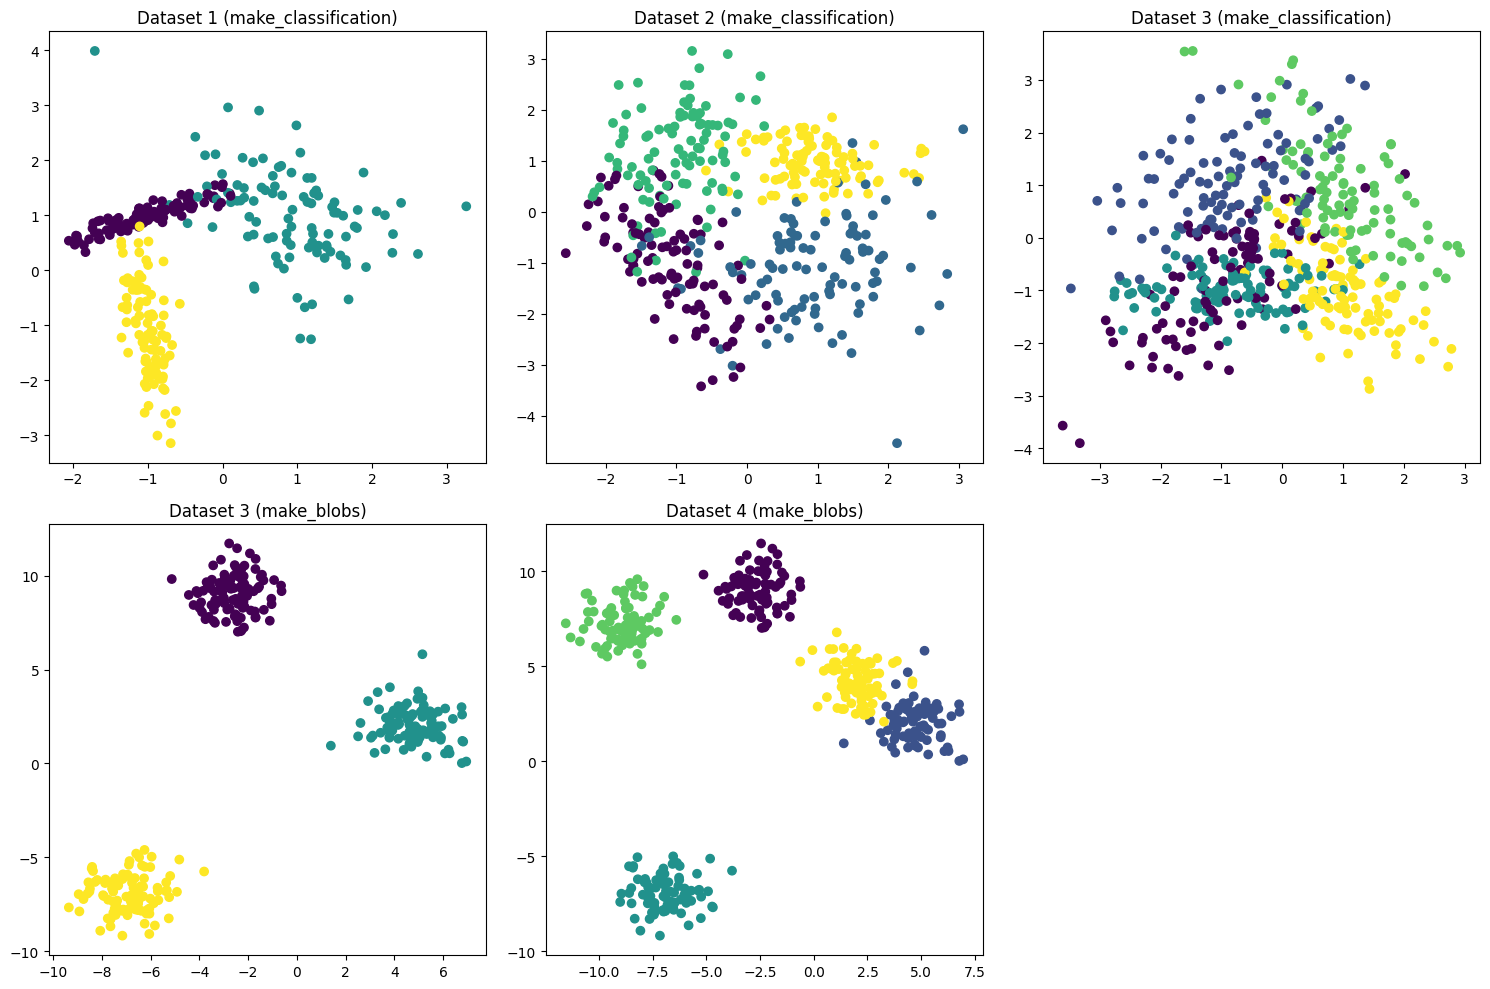

In [5]:
# Визуализация 2D датасетов
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.scatter(X_class1[:, 0], X_class1[:, 1], c=y_class1)
plt.title("Dataset 1 (make_classification)")

plt.subplot(232)
plt.scatter(X_class2[:, 0], X_class2[:, 1], c=y_class2)
plt.title("Dataset 2 (make_classification)")

plt.subplot(233)
plt.scatter(X_class3[:, 0], X_class3[:, 1], c=y_class3)
plt.title("Dataset 3 (make_classification)")

plt.subplot(234)
plt.scatter(X_blobs1[:, 0], X_blobs1[:, 1], c=y_blobs1)
plt.title("Dataset 3 (make_blobs)")

plt.subplot(235)
plt.scatter(X_blobs2[:, 0], X_blobs2[:, 1], c=y_blobs2)
plt.title("Dataset 4 (make_blobs)")

plt.tight_layout()
plt.show()

## В соответствии с индивидуальным вариантом загрузите предобработанный датасет в формате CSV для решения задачи классификации. Удалите метку класса. 

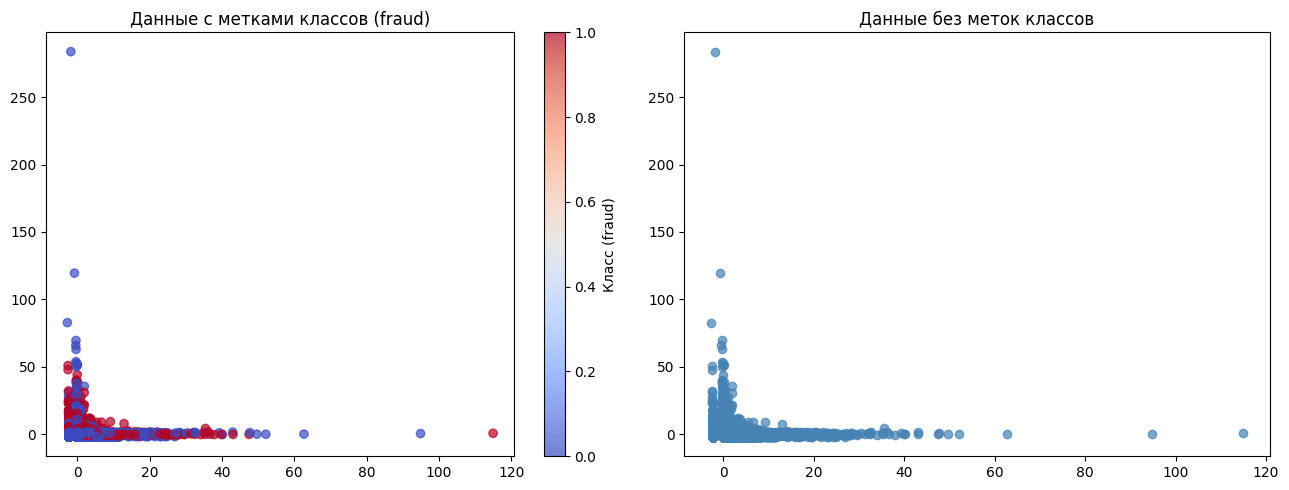

In [44]:
# Загрузка и подготовка данных
df = pd.read_csv('data_newKredit.csv')
y = df['fraud']  # Метки классов
X = df.drop('fraud', axis=1)  # Признаки

# Преобразование категориальных переменных
X = pd.get_dummies(X, drop_first=True)

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Уменьшение размерности для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализация
plt.figure(figsize=(13, 5))

# График с метками классов
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('Данные с метками классов (fraud)')
plt.colorbar(scatter, label='Класс (fraud)')

# График без меток классов
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='steelblue', alpha=0.7)
plt.title('Данные без меток классов')

plt.tight_layout()
plt.show()

# Решение задачи кластеризации

## Реализовать следующие алгоритмы кластеризации на синтетических данных: k-means, иерархическая кластеризация, DBSCAN, EM-алгоритм, Affinity Propagation.  

In [45]:
def generate_synthetic_data(): 
    return [(data1, data_y1, "Dataset 1 (3 класса)"),
            (data2, data_y2, "Dataset 2 (4 класса)"),
            (data3, data_y3, "Dataset 3 (5 классов)"),
            (data4, data_y4, "Dataset 4 (3 кластера)"),
            (data5, data_y5, "Dataset 5 (5 кластеров)")]

In [49]:
# Функции для подбора параметров

def find_optimal_k(X, max_k=10):
    """Оптимизация числа кластеров для K-means"""
    distortions = []
    silhouette_scores = []
    K_range = range(2, max_k+1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
        
        if len(np.unique(kmeans.labels_)) > 1:
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        else:
            silhouette_scores.append(-1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(K_range, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    
    plt.subplot(122)
    plt.plot(K_range, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')
    
    plt.tight_layout()
    plt.show()
    
    return K_range[np.argmax(silhouette_scores)]

def optimize_dbscan(X, eps_values=np.linspace(0.1, 1.0, 10), min_samples_values=[5, 10, 15]):
    """Полный перебор параметров для DBSCAN"""
    best_score = -1
    best_params = {'eps': 0.5, 'min_samples': 5}
    
    for eps, min_samples in product(eps_values, min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
    
    print(f"Optimal DBSCAN params: {best_params} (silhouette: {best_score:.3f})")
    return best_params

def optimize_gmm(X, max_components=10):
    """Оптимизация числа компонент для GMM"""
    best_score = -1
    best_n = 2
    
    for n in range(2, max_components+1):
        gmm = GaussianMixture(n_components=n, random_state=42)
        labels = gmm.fit_predict(X)
        
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_n = n
    
    print(f"Optimal GMM components: {best_n} (silhouette: {best_score:.3f})")
    return best_n

def optimize_affinity_propagation(X, damping_values=[0.5, 0.6, 0.7, 0.8, 0.9]):
    """Оптимизация damping для Affinity Propagation"""
    best_score = -1
    best_damping = 0.5
    
    for damping in damping_values:
        af = AffinityPropagation(damping=damping, random_state=42)
        labels = af.fit_predict(X)
        
        if len(np.unique(labels)) > 1:
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_damping = damping
    
    print(f"Optimal damping: {best_damping} (silhouette: {best_score:.3f})")
    return best_damping

def optimize_hierarchical(X, max_clusters=10):
    """Оптимизация числа кластеров для иерархической кластеризации"""
    best_score = -1
    best_n = 2
    
    for n in range(2, max_clusters+1):
        agg = AgglomerativeClustering(n_clusters=n)
        labels = agg.fit_predict(X)
        
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_n = n
    
    print(f"Optimal hierarchical clusters: {best_n} (silhouette: {best_score:.3f})")
    return best_n

In [50]:
# Визуализация и анализ

def plot_clusters(X, y_pred, title, true_labels=None, is_3d=False):
    plt.figure(figsize=(10, 6))
    
    if is_3d:
        ax = plt.axes(projection='3d')
        scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred, cmap='viridis', s=30)
        ax.set_zlabel('Feature 3')
    else:
        ax = plt.gca()
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', s=30)
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'{title}\nNumber of clusters: {len(np.unique(y_pred))}')
    plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.show()

def analyze_clusters(df, cluster_labels, dataset_name=""):
    df['cluster'] = cluster_labels
    
    print(f"\nCluster analysis for {dataset_name}:")
    print("="*50)
    print("\nCluster sizes:")
    print(df['cluster'].value_counts().sort_index())
    
    print("\nCluster characteristics:")
    cluster_stats = df.groupby('cluster').mean()
    display(cluster_stats)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_stats.T, cmap='YlGnBu', annot=True, fmt=".2f")
    plt.title(f'Cluster Characteristics for {dataset_name}')
    plt.tight_layout()
    plt.show()
    
    return df



=== Clustering on Dataset 1 (3 класса) ===


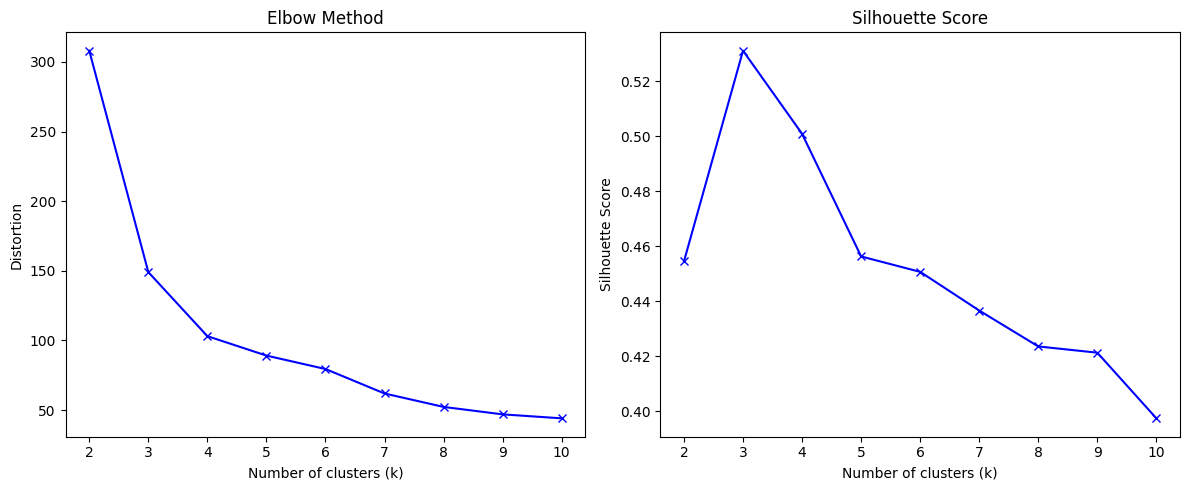

Optimal DBSCAN params: {'eps': 0.7000000000000001, 'min_samples': 5} (silhouette: 0.487)
Optimal GMM components: 3 (silhouette: 0.476)
Optimal damping: 0.5 (silhouette: 0.414)
Optimal hierarchical clusters: 3 (silhouette: 0.523)

Analyzing K-means results:


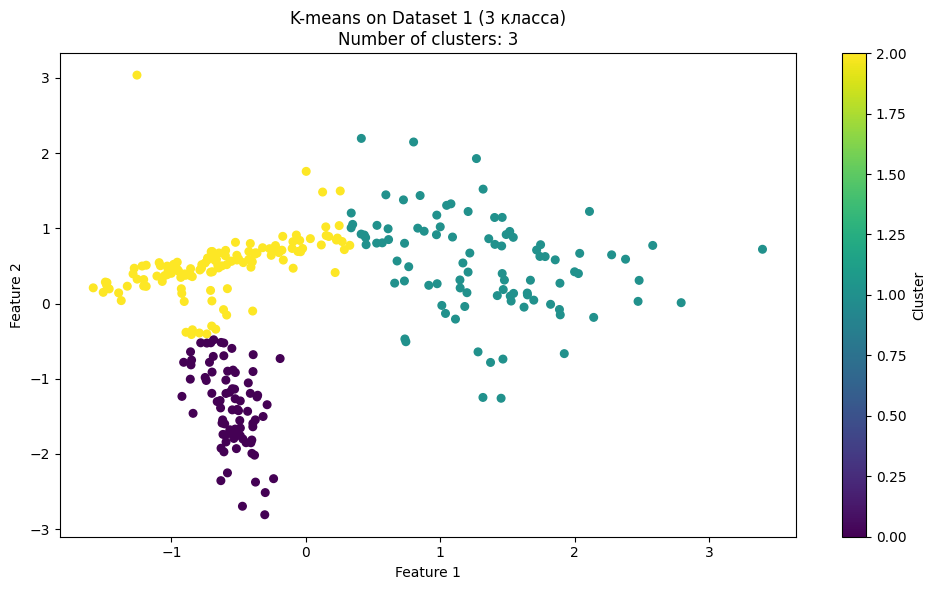


Cluster analysis for Dataset 1 (3 класса) (K-means):

Cluster sizes:
cluster
0     82
1     94
2    124
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -0.554242  -1.380295    2.000000
1         1.312077   0.530306    0.957447
2        -0.628124   0.510769    0.370968

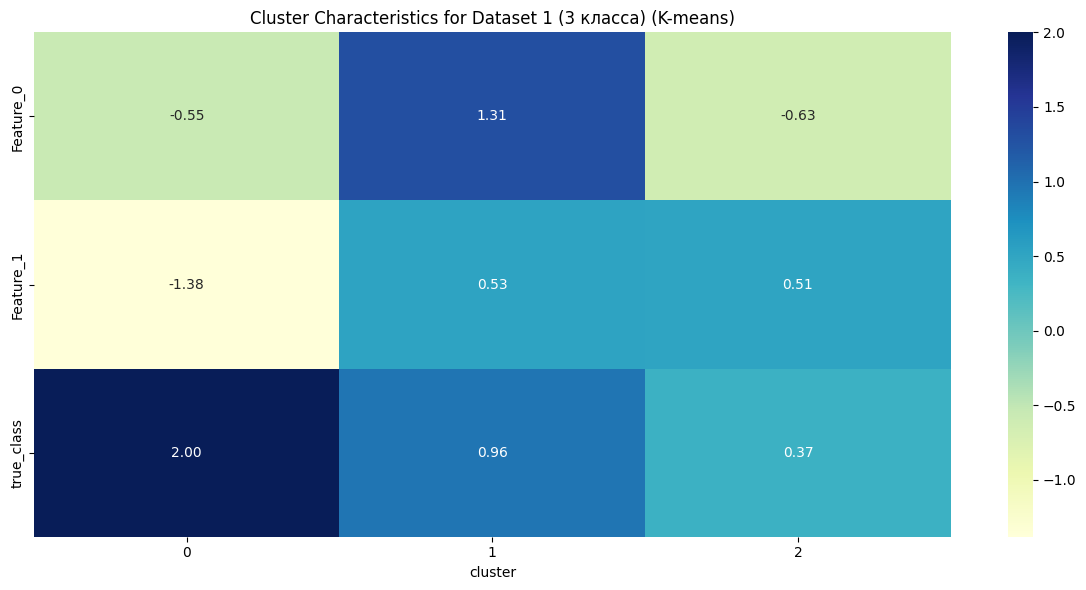


Analyzing DBSCAN results:


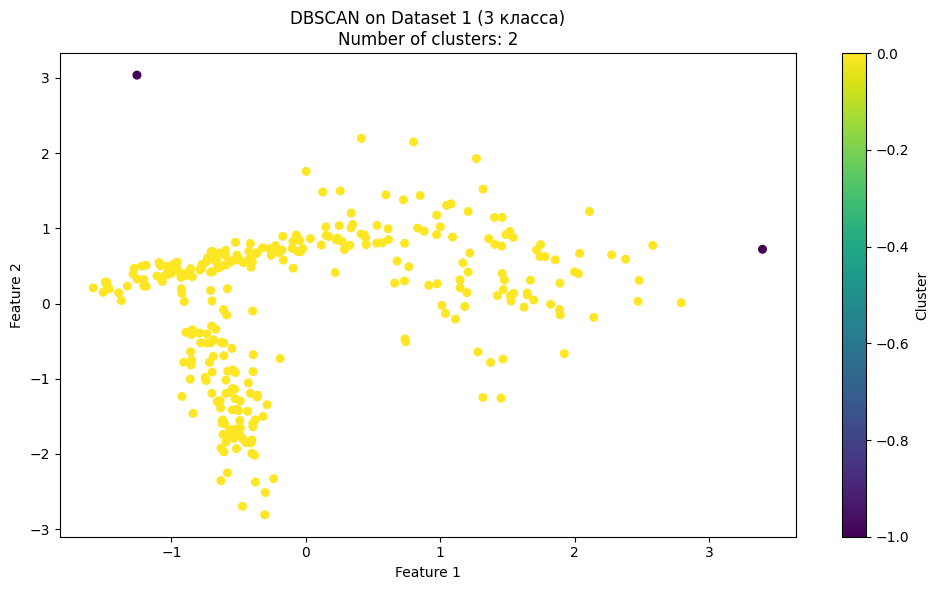


Cluster analysis for Dataset 1 (3 класса) (DBSCAN):

Cluster sizes:
cluster
-1      2
 0    298
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
-1        1.071405   1.879299         1.0
 0       -0.007191  -0.012613         1.0

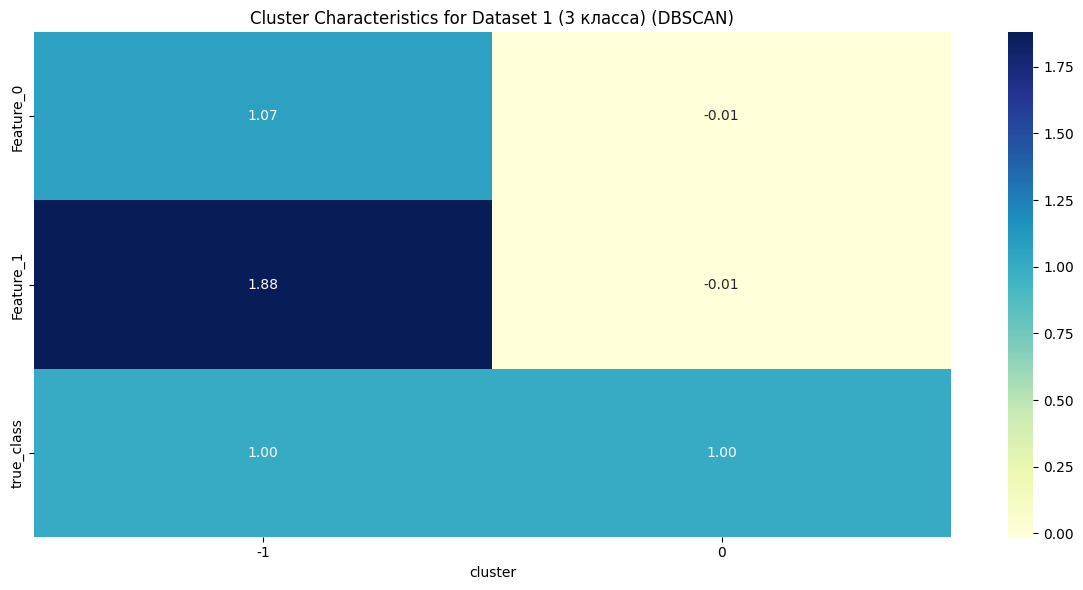


Analyzing GMM results:


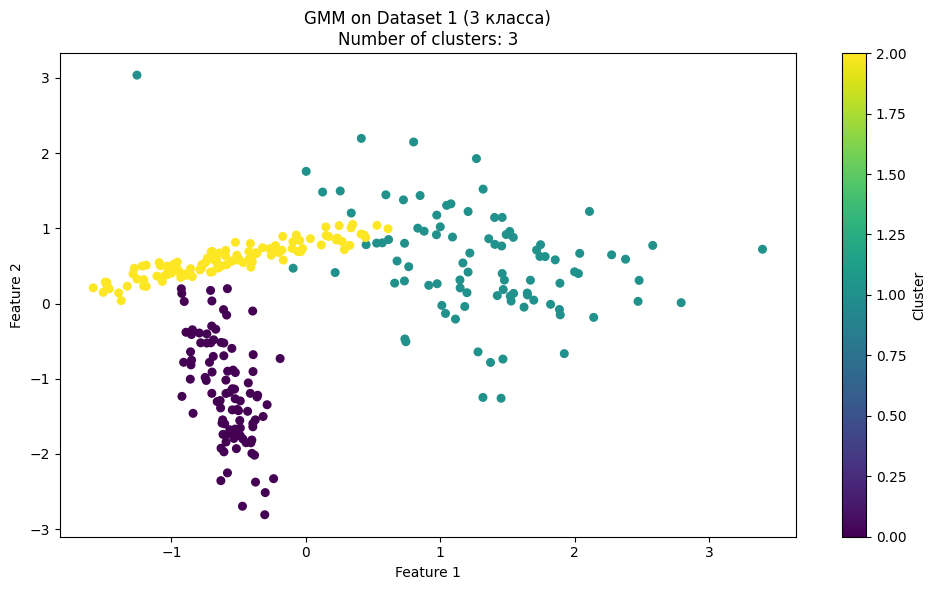


Cluster analysis for Dataset 1 (3 класса) (GMM):

Cluster sizes:
cluster
0     98
1     93
2    109
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -0.584385  -1.176938    2.000000
1         1.284585   0.555933    1.000000
2        -0.570611   0.583836    0.100917

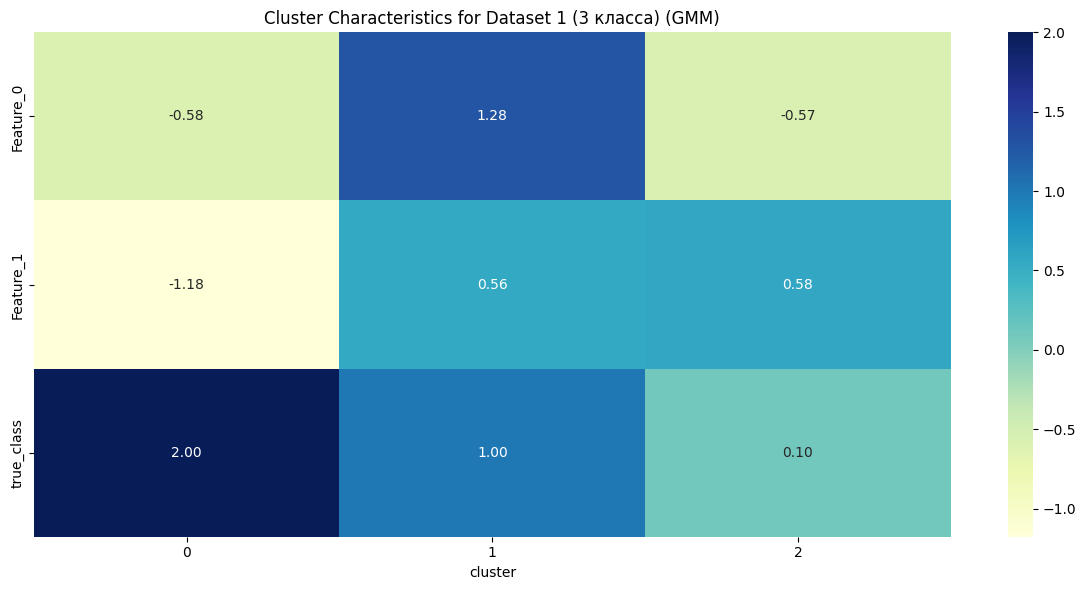


Analyzing AffinityProp results:


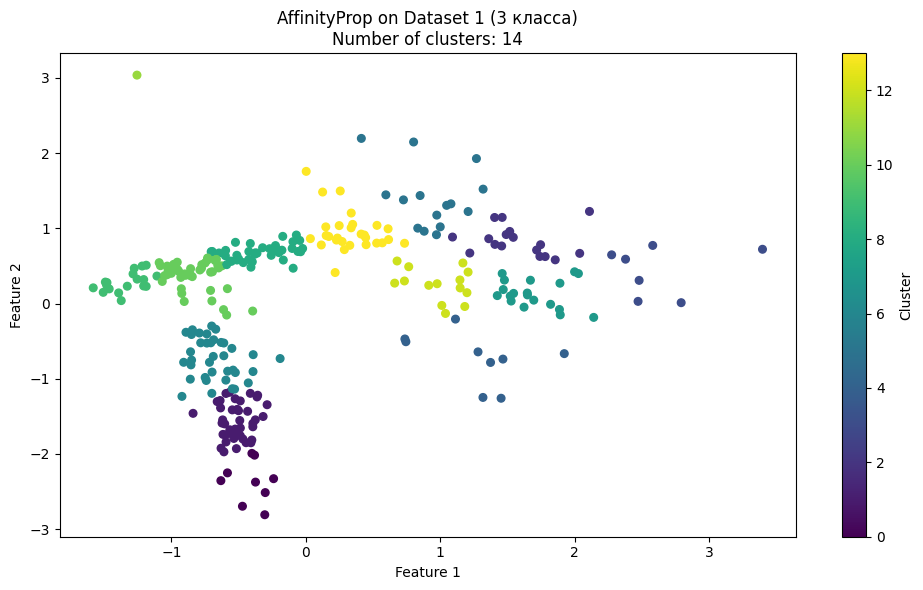


Cluster analysis for Dataset 1 (3 класса) (AffinityProp):

Cluster sizes:
cluster
0      9
1     43
2     17
3      7
4      9
5     15
6     37
7     19
8     39
9     18
10    44
11     1
12    14
13    28
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -0.409760  -2.371463    2.000000
1        -0.516044  -1.563956    2.000000
2         1.585747   0.836907    1.000000
3         2.626421   0.439622    1.000000
4         1.268635  -0.725430    1.000000
5         0.932026   1.398583    1.000000
6        -0.677109  -0.734427    2.000000
7         1.704793   0.131125    1.000000
8        -0.343541   0.675741    0.051282
9        -1.334916   0.283947    0.000000
10       -0.830595   0.380621    0.500000
11       -1.256177   3.037366    1.000000
12        0.988863   0.253862    1.000000
13        0.327993   0.954190    0.571429

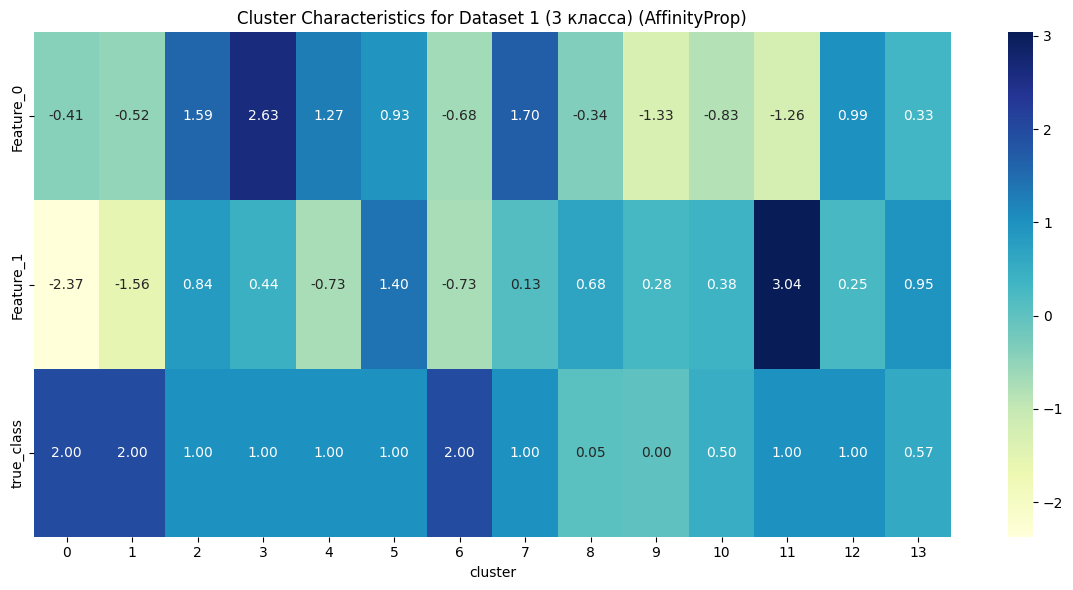


Analyzing Hierarchical results:


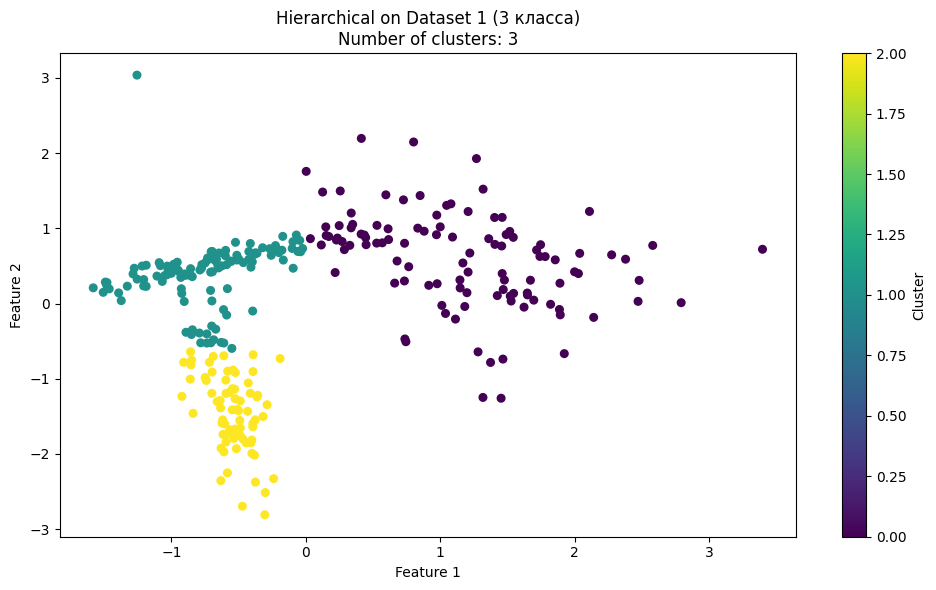


Cluster analysis for Dataset 1 (3 класса) (Hierarchical):

Cluster sizes:
cluster
0    109
1    116
2     75
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0         1.157428   0.591903    0.889908
1        -0.736309   0.387696    0.456897
2        -0.543304  -1.459868    2.000000

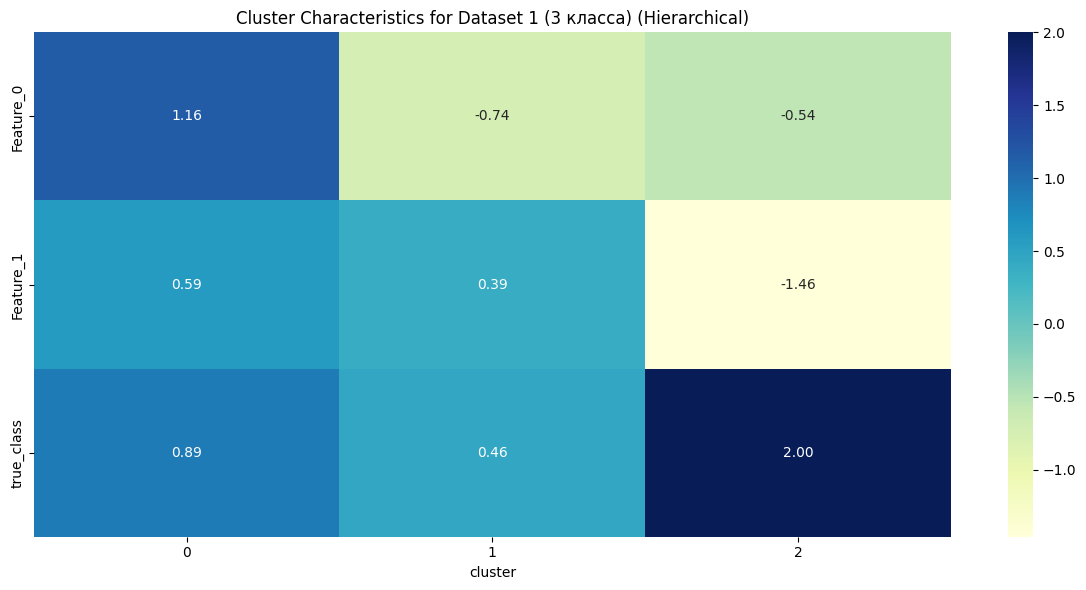



=== Clustering on Dataset 2 (4 класса) ===


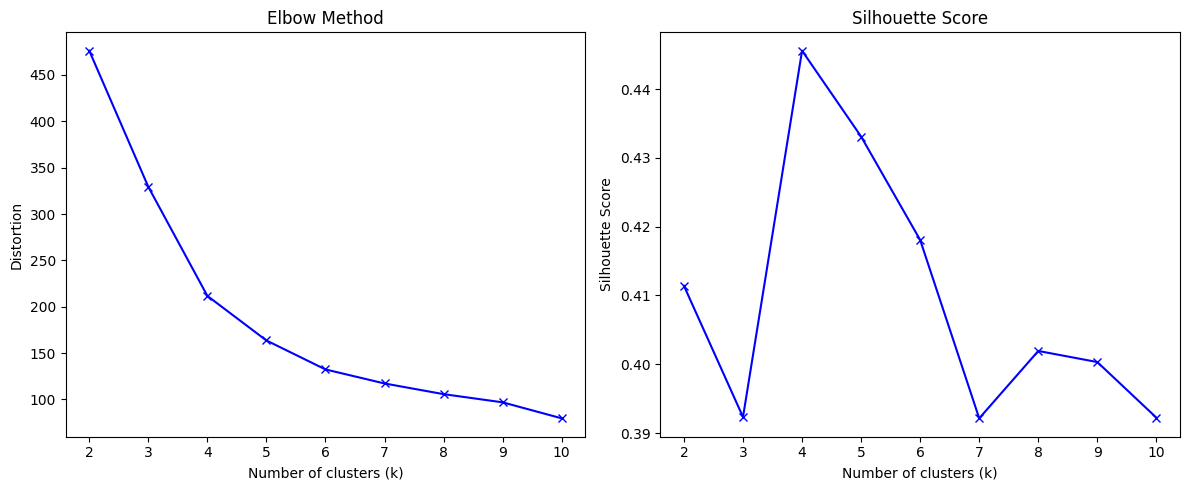

Optimal DBSCAN params: {'eps': 1.0, 'min_samples': 10} (silhouette: 0.479)
Optimal GMM components: 2 (silhouette: 0.410)
Optimal damping: 0.8 (silhouette: 0.373)
Optimal hierarchical clusters: 4 (silhouette: 0.415)

Analyzing K-means results:


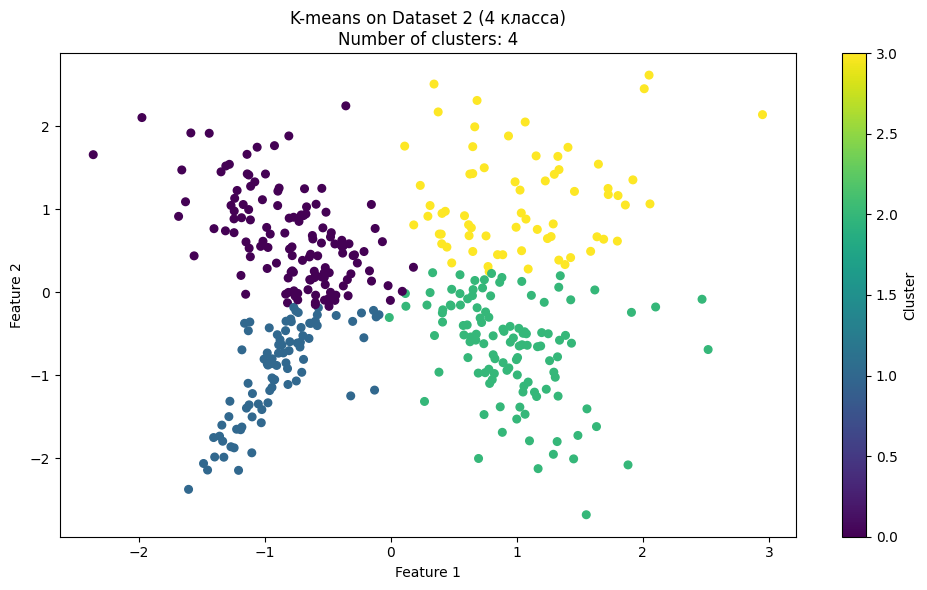


Cluster analysis for Dataset 2 (4 класса) (K-means):

Cluster sizes:
cluster
0    132
1     86
2    115
3     67
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -0.771557   0.636361    1.689394
1        -0.897649  -0.949834    0.348837
2         0.948341  -0.664834    1.391304
3         1.044540   1.106598    2.716418

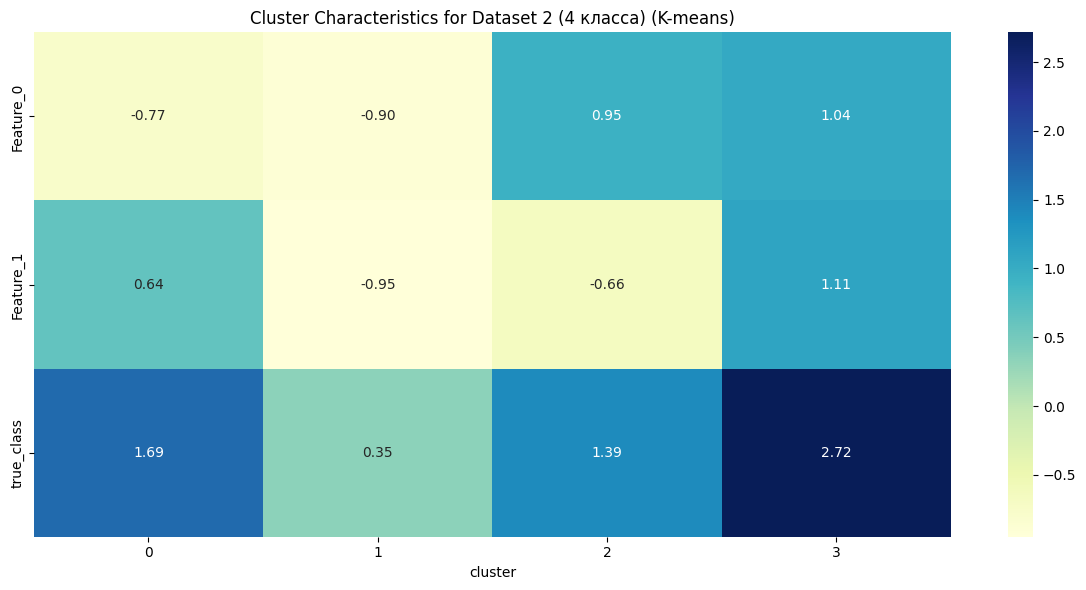


Analyzing DBSCAN results:


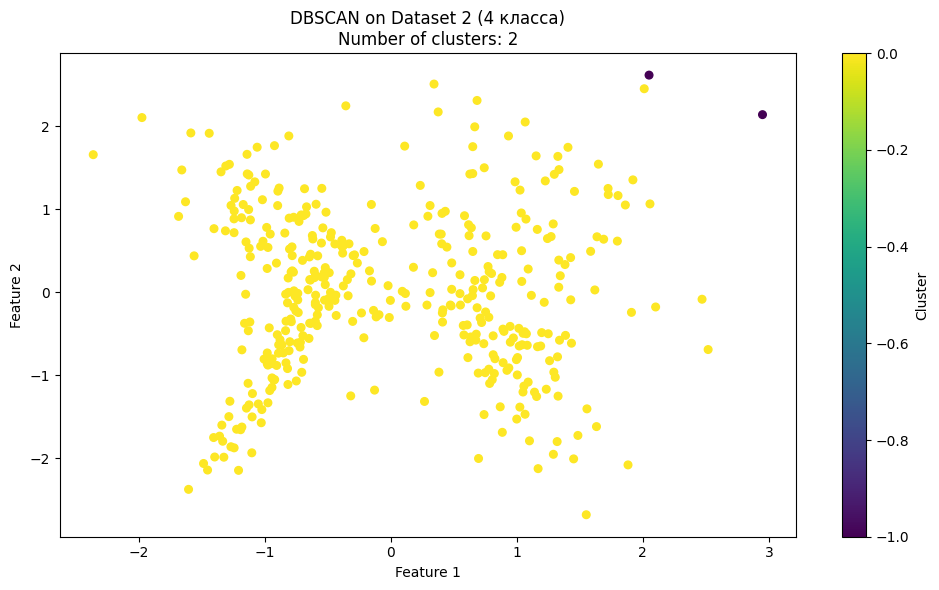


Cluster analysis for Dataset 2 (4 класса) (DBSCAN):

Cluster sizes:
cluster
-1      2
 0    398
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
-1        2.499186   2.376068    3.000000
 0       -0.012559  -0.011940    1.479899

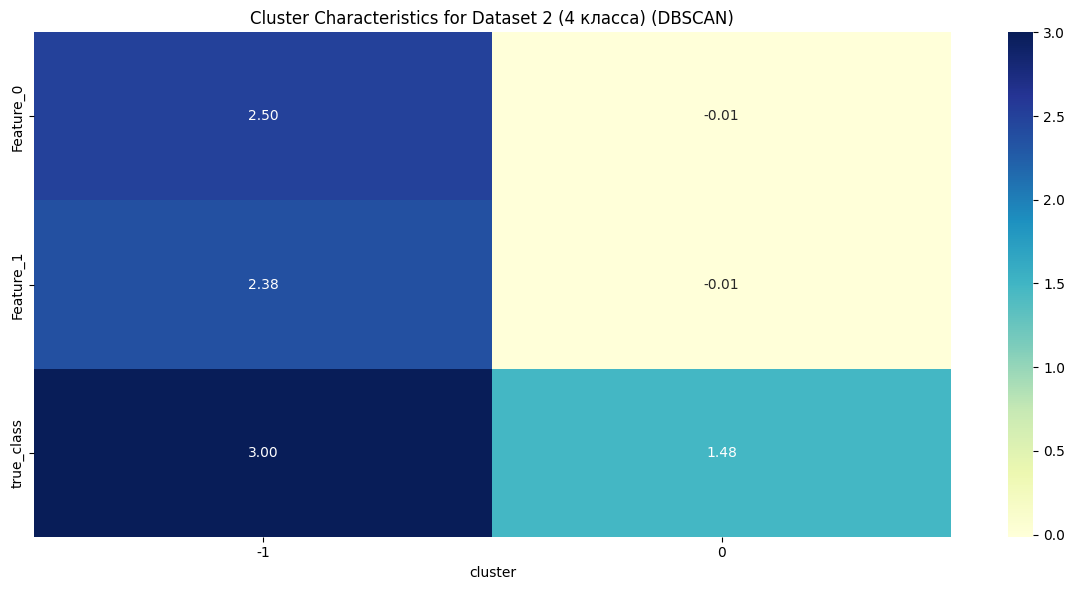


Analyzing GMM results:


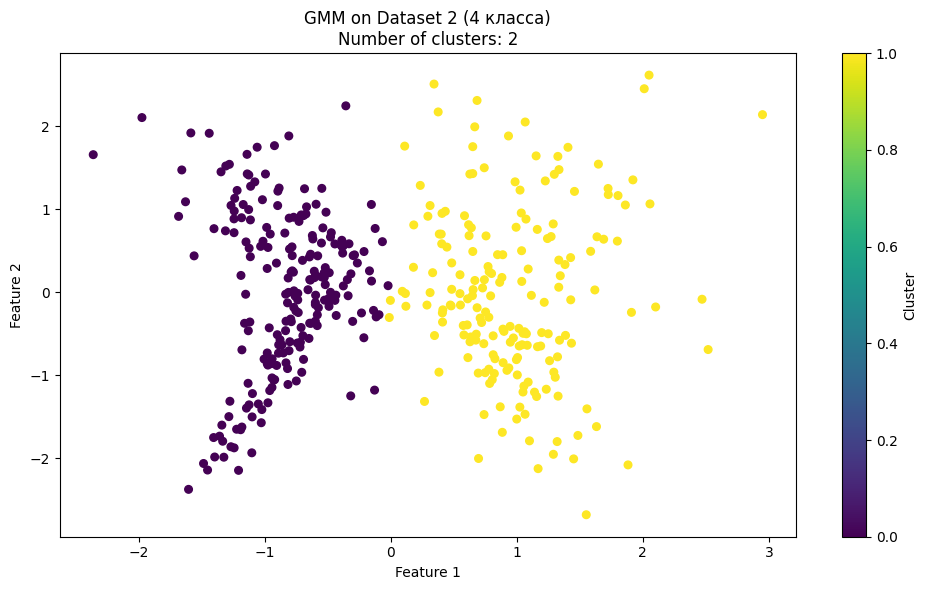


Cluster analysis for Dataset 2 (4 класса) (GMM):

Cluster sizes:
cluster
0    215
1    185
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -0.834004   0.009761    1.144186
1         0.969247  -0.011344    1.886486

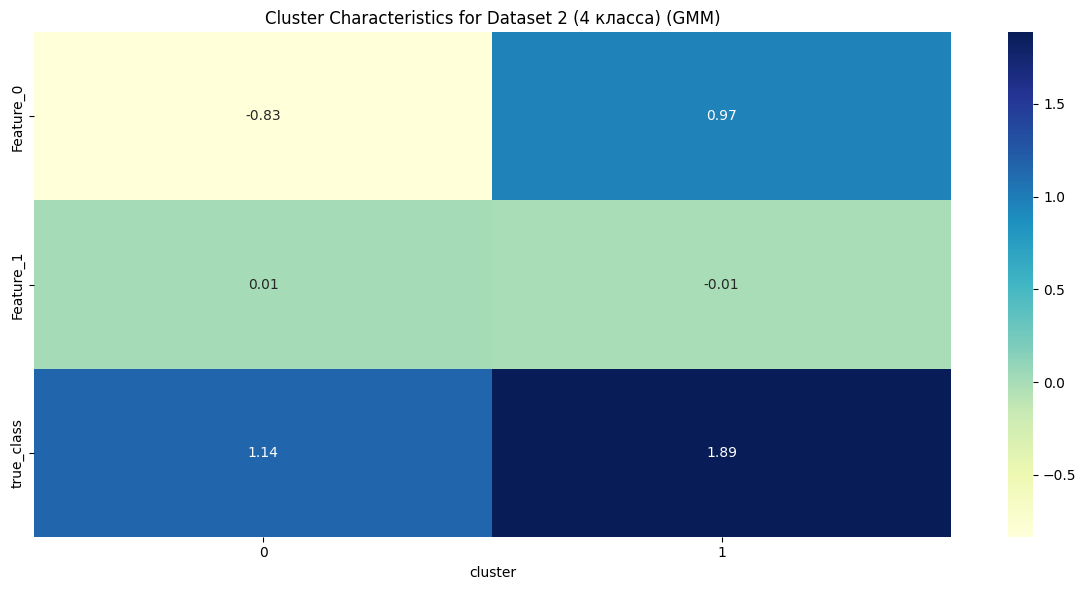


Analyzing AffinityProp results:


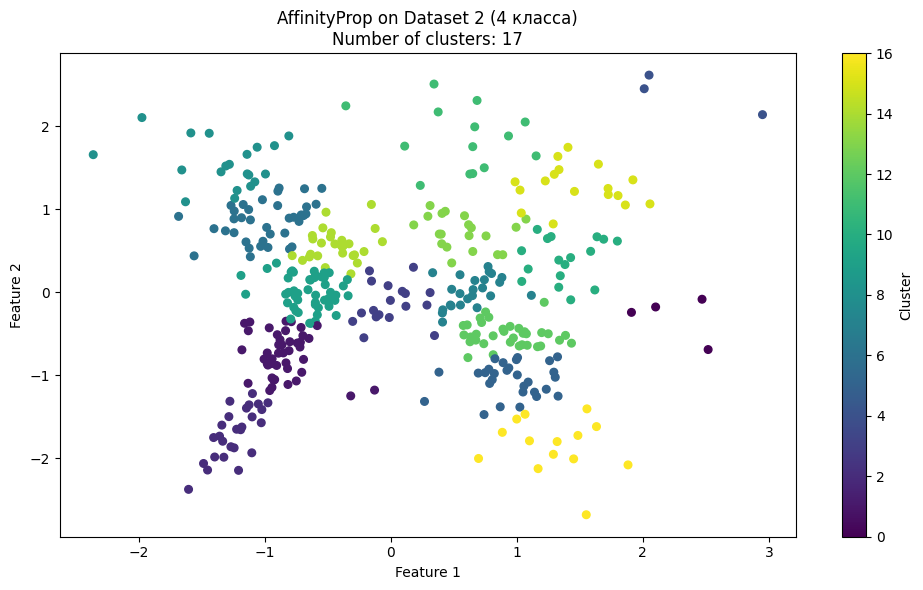


Cluster analysis for Dataset 2 (4 класса) (AffinityProp):

Cluster sizes:
cluster
0      4
1     44
2     26
3     18
4      3
5     29
6     37
7     24
8     20
9     50
10    17
11    14
12    35
13    20
14    28
15    17
16    14
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0         2.249595  -0.297927    3.000000
1        -0.848844  -0.747122    0.272727
2        -1.239781  -1.695306    0.000000
3        -0.000212  -0.133840    2.055556
4         2.336420   2.400705    3.000000
5         0.956127  -1.050289    1.068966
6        -0.997582   0.851195    2.054054
7         0.641065   0.010517    1.291667
8        -1.321610   1.546867    2.050000
9        -0.649909   0.000393    1.120000
10        1.377529   0.396241    2.882353
11        0.562717   1.853095    2.857143
12        0.928197  -0.509166    1.457143
13        0.570656   0.725312    2.350000
14       -0.431870   0.564785    1.357143
15        1.477633   1.280463    3.000000
16        1.291510  -1.845850    1.000000

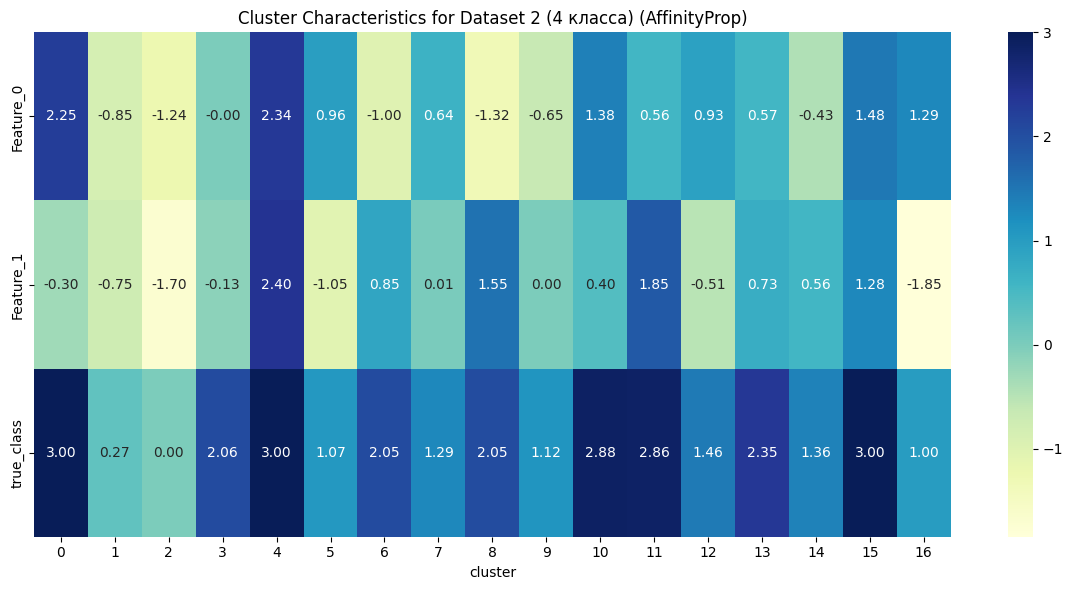


Analyzing Hierarchical results:


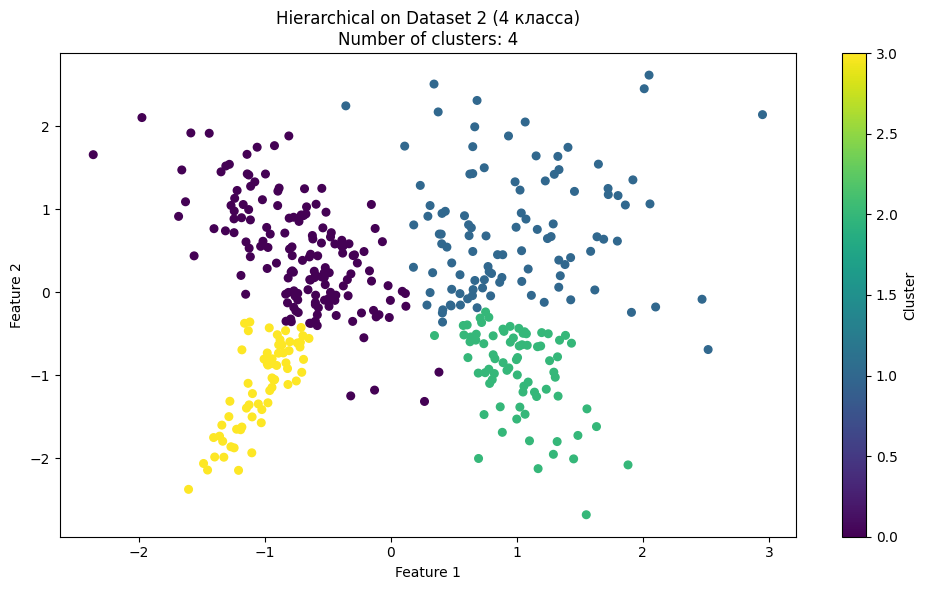


Cluster analysis for Dataset 2 (4 класса) (Hierarchical):

Cluster sizes:
cluster
0    156
1    103
2     76
3     65
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -0.711932   0.451473    1.602564
1         0.982696   0.730477    2.388350
2         1.010204  -0.950605    1.210526
3        -1.029720  -1.129584    0.107692

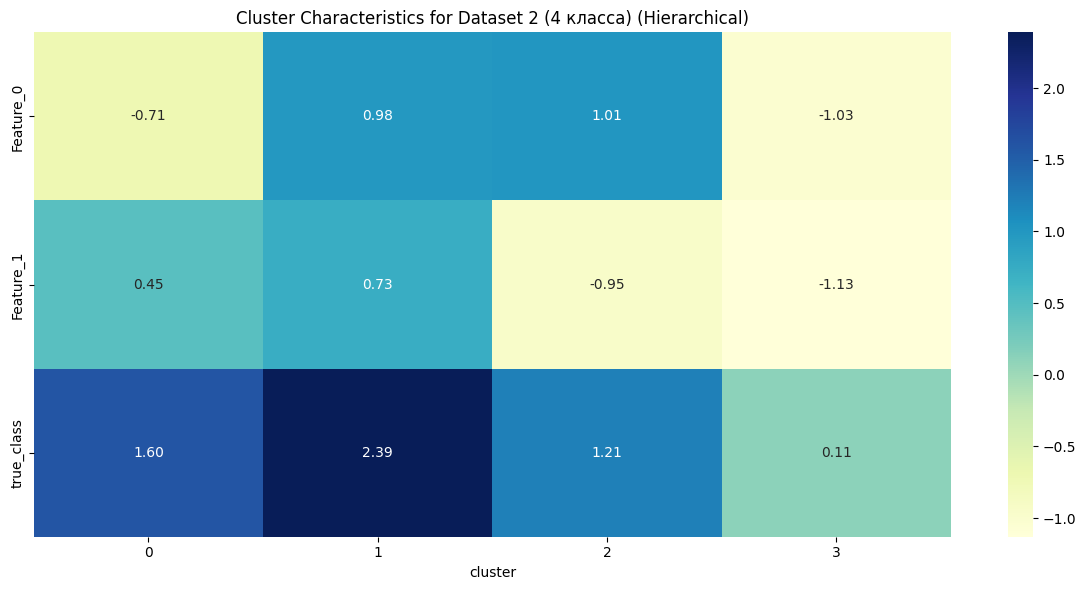



=== Clustering on Dataset 3 (5 классов) ===


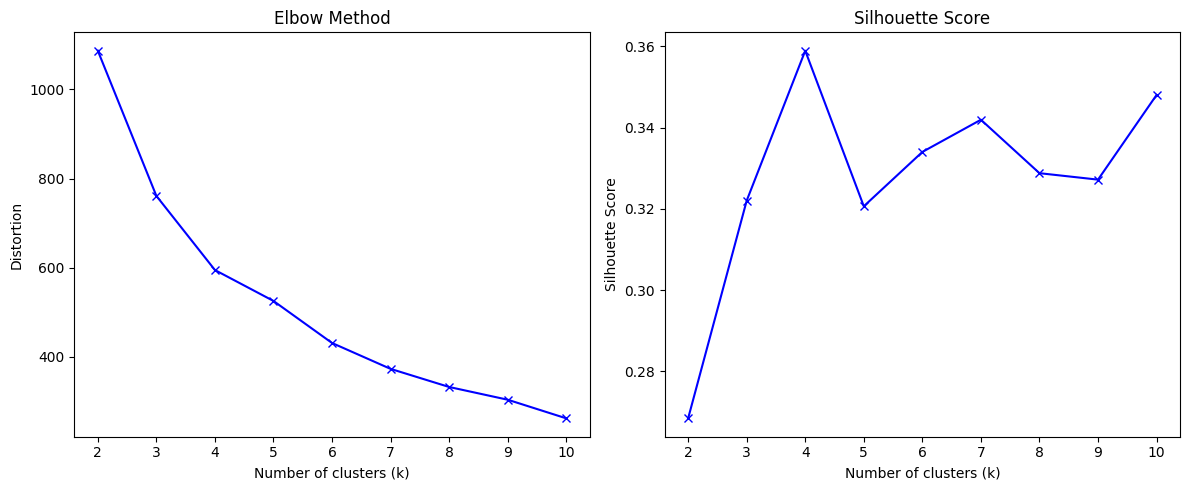

Optimal DBSCAN params: {'eps': 1.0, 'min_samples': 15} (silhouette: 0.376)
Optimal GMM components: 4 (silhouette: 0.294)
Optimal damping: 0.7 (silhouette: 0.324)
Optimal hierarchical clusters: 9 (silhouette: 0.332)

Analyzing K-means results:


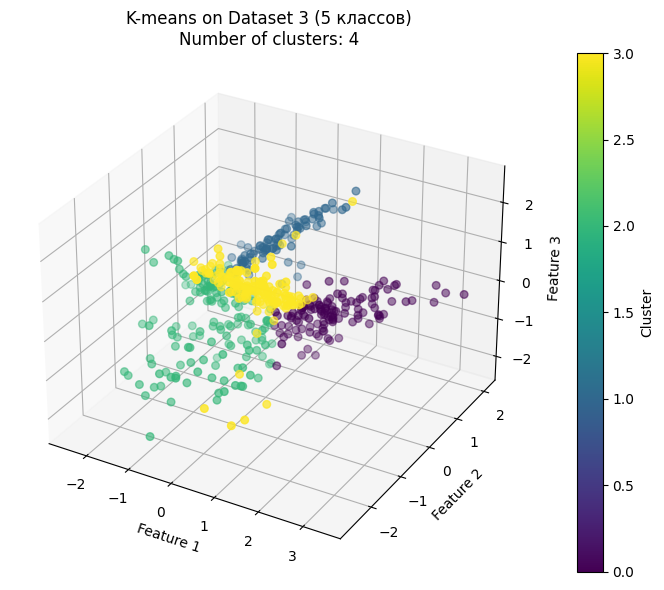


Cluster analysis for Dataset 3 (5 классов) (K-means):

Cluster sizes:
cluster
0    120
1     88
2    150
3    142
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  Feature_2  true_class
cluster                                             
0         0.991072   0.880384  -0.697310    1.525000
1        -0.396107   0.991279   0.667720    3.806818
2        -0.956033  -0.415121  -0.691884    1.513333
3         0.417843  -0.919792   0.906340    1.739437

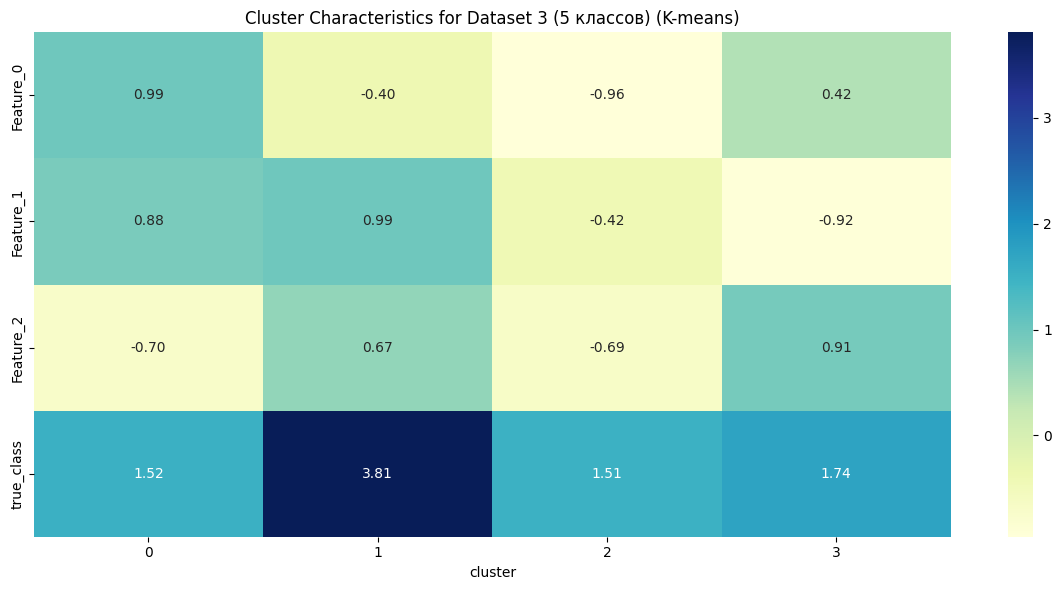


Analyzing DBSCAN results:


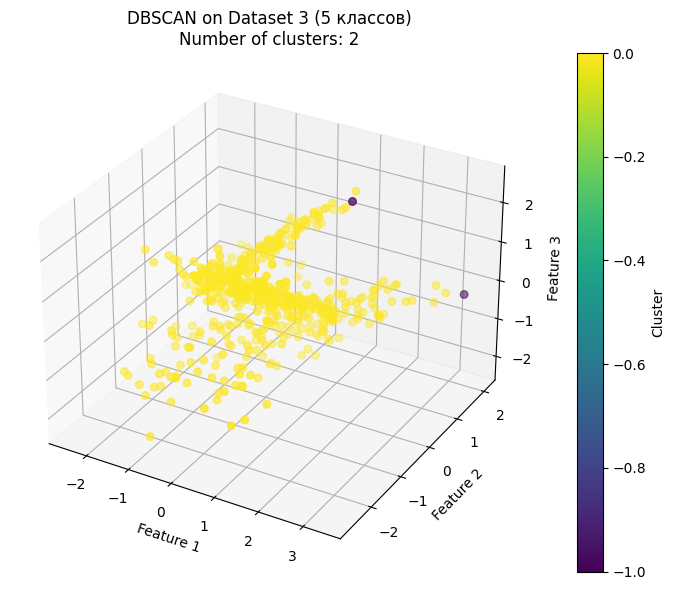


Cluster analysis for Dataset 3 (5 классов) (DBSCAN):

Cluster sizes:
cluster
-1      2
 0    498
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  Feature_2  true_class
cluster                                             
-1        2.507148    1.17286   1.240814    2.500000
 0       -0.010069   -0.00471  -0.004983    1.981928

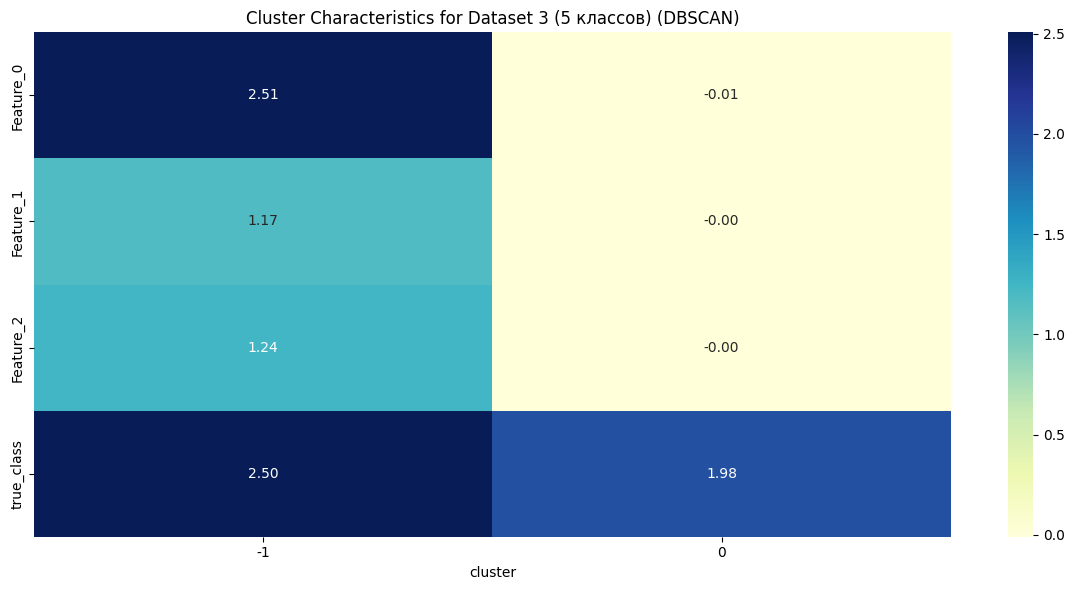


Analyzing GMM results:


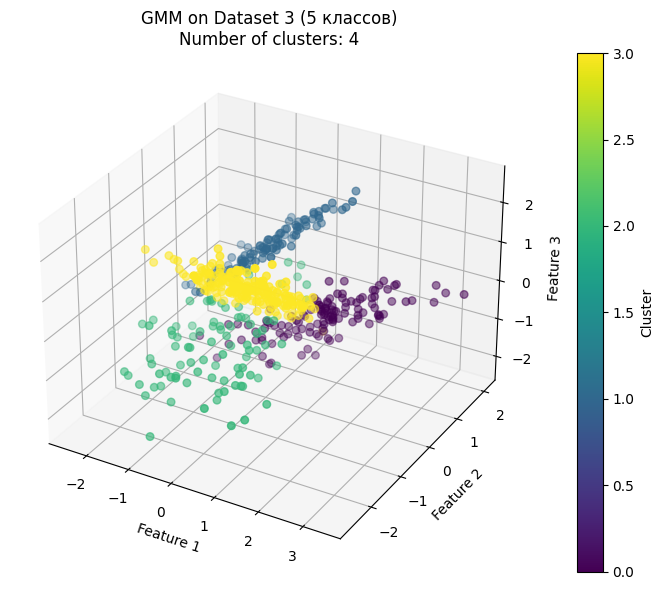


Cluster analysis for Dataset 3 (5 классов) (GMM):

Cluster sizes:
cluster
0    120
1    100
2     91
3    189
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  Feature_2  true_class
cluster                                             
0         0.791888   0.902839  -0.873457    1.291667
1        -0.518599   0.892399   0.621916    3.830000
2        -0.617373  -0.774461  -0.947817    1.912088
3         0.068858  -0.672511   0.681876    1.481481

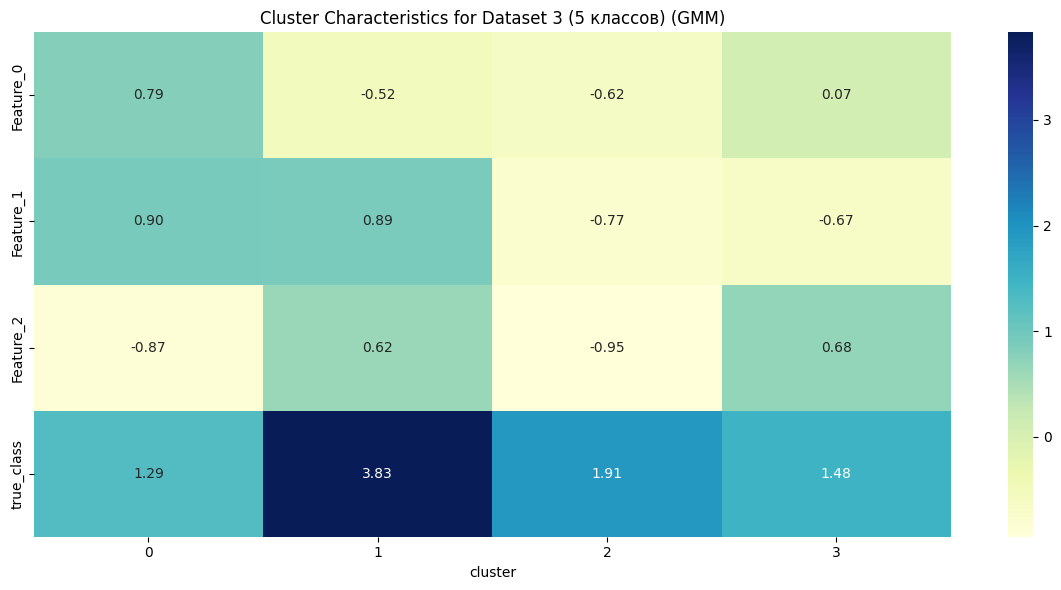


Analyzing AffinityProp results:


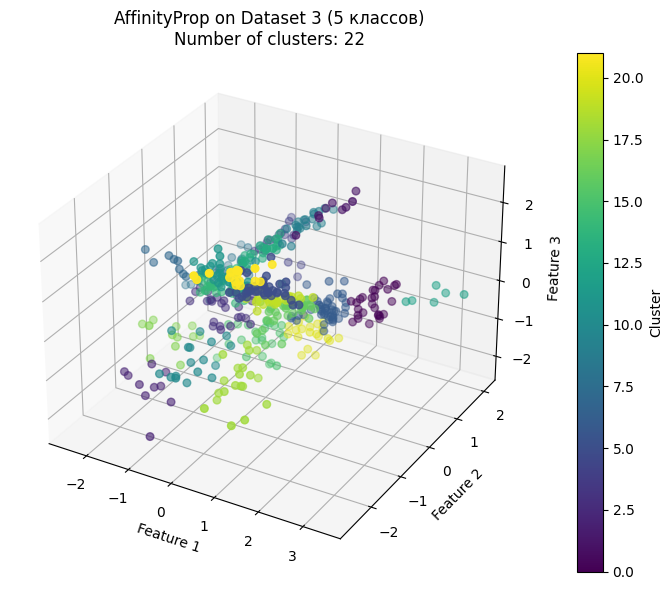


Cluster analysis for Dataset 3 (5 классов) (AffinityProp):

Cluster sizes:
cluster
0     27
1      9
2     10
3     25
4     20
5     38
6     46
7     11
8     23
9     20
10    17
11    32
12     6
13    28
14    33
15    25
16    32
17    12
18    20
19    29
20    21
21    16
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  Feature_2  true_class
cluster                                             
0         1.640181   1.271932  -0.508215    1.000000
1         0.933847   0.867682   1.943662    4.000000
2        -1.562017  -1.635147  -1.713414    2.000000
3        -0.931647  -0.079109  -0.498343    1.280000
4        -0.696954   1.476800   0.259083    3.700000
5         0.769132  -1.105472   1.187798    2.315789
6         0.816909   0.848595  -0.627627    1.500000
7        -1.749697  -0.418154   0.505008    0.181818
8        -1.596111   0.988316  -0.400011    3.739130
9         0.192225   1.068695   1.258258    4.000000
10       -0.729363  -1.286432  -0.945125    2.000000
11       -0.405769  -0.770152   0.954800    0.125000
12        2.772604   1.670529  -0.229514    1.000000
13       -0.471016   0.560759   0.637351    3.678571
14       -0.834900  -0.300567   0.240733    0.606061
15       -0.397074   0.356820  -1.429885    1.320000
16        0.610312  -0.100363  -0.120875    2.500000
17       -1.816502  -0.581693  -1.202167    2.000000
18        0.375621  -1.412328  -1.079351    2.000000
19        0.597455  -0.556746   0.534067    1.931034
20        0.459882   0.892919  -1.421973    1.571429
21        0.790990  -2.016885   2.122289    2.812500

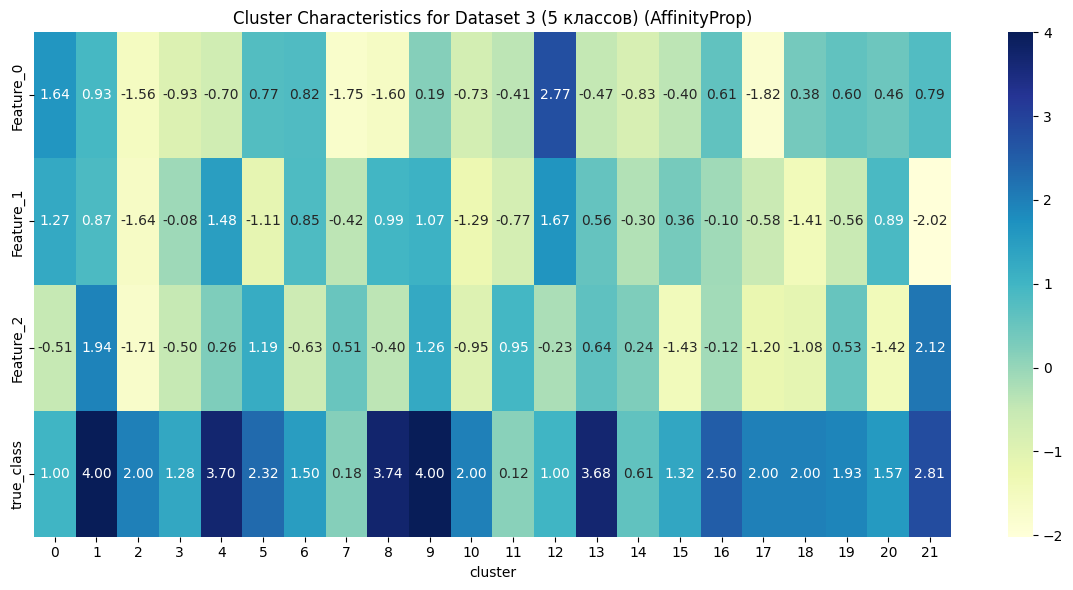


Analyzing Hierarchical results:


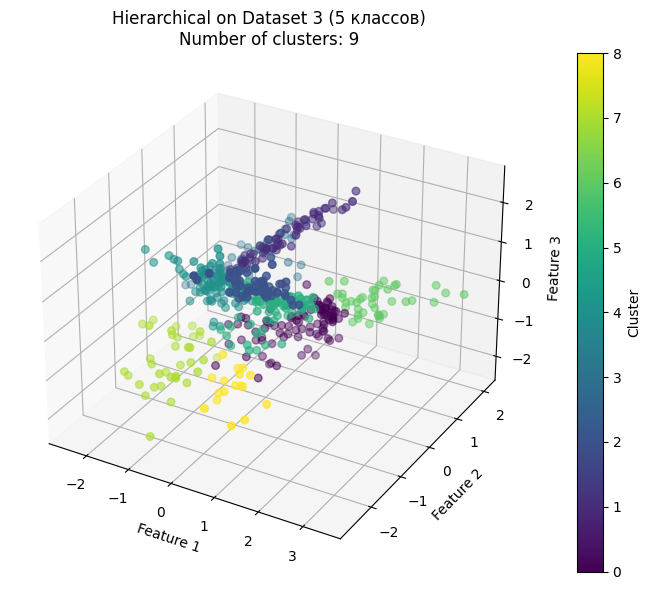


Cluster analysis for Dataset 3 (5 классов) (Hierarchical):

Cluster sizes:
cluster
0    89
1    60
2    55
3    43
4    84
5    76
6    40
7    36
8    17
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  Feature_2  true_class
cluster                                             
0         0.329051   0.665427  -1.073084    1.505618
1        -0.063260   0.748410   1.038262    3.883333
2         0.772850  -1.365763   1.451966    2.472727
3        -1.177898   1.215518  -0.093456    3.720930
4        -0.920888  -0.415474   0.327847    0.357143
5         0.453703  -0.384424   0.144775    1.986842
6         1.713975   1.280496  -0.418652    1.025000
7        -1.372200  -1.156538  -1.262193    2.027778
8         0.374489  -1.573315  -1.116928    2.000000

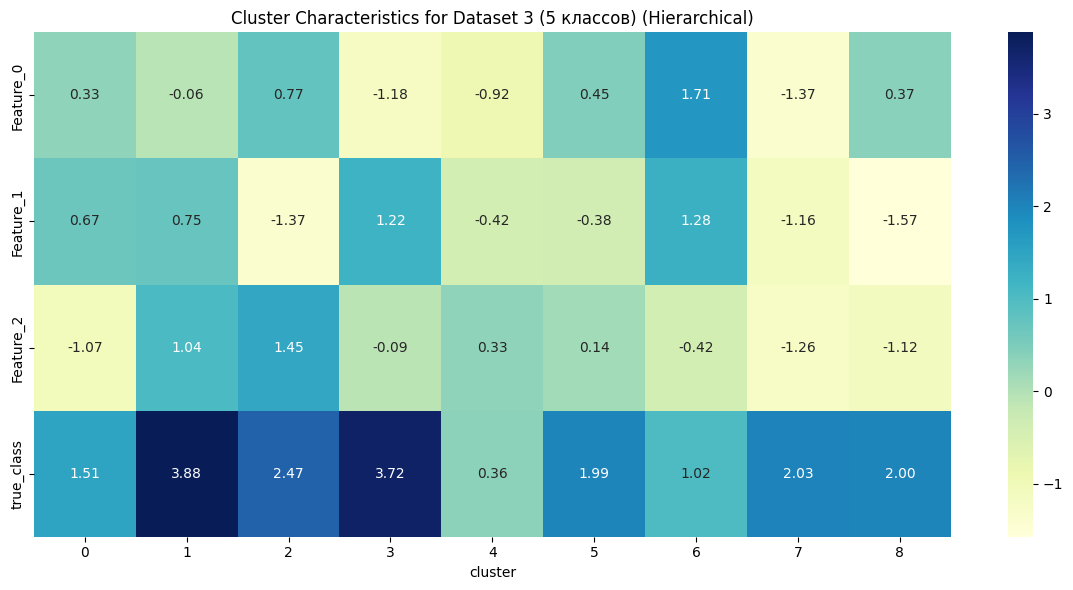



=== Clustering on Dataset 4 (3 кластера) ===


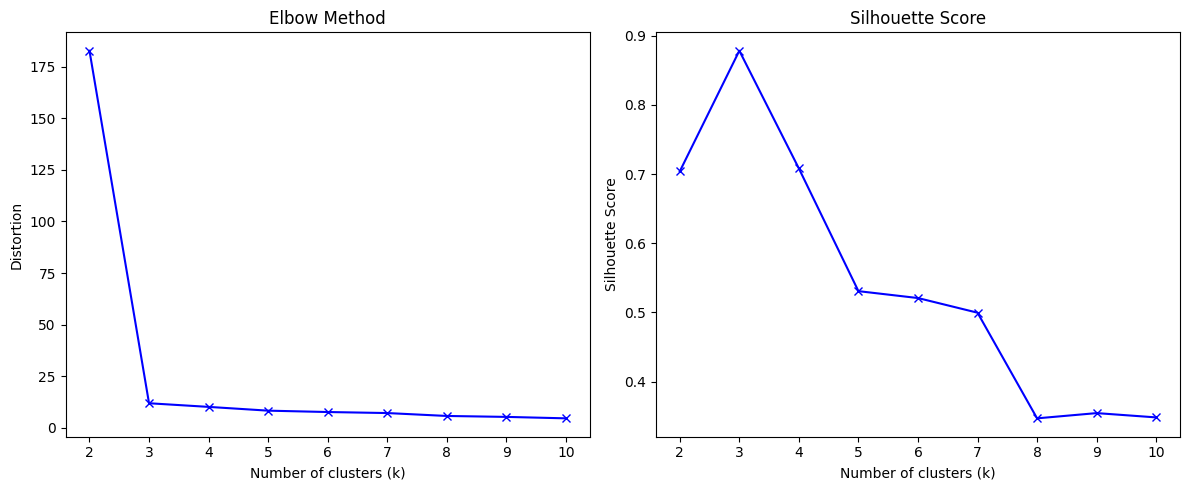

Optimal DBSCAN params: {'eps': 0.30000000000000004, 'min_samples': 5} (silhouette: 0.878)
Optimal GMM components: 3 (silhouette: 0.878)
Optimal damping: 0.5 (silhouette: 0.878)
Optimal hierarchical clusters: 3 (silhouette: 0.878)

Analyzing K-means results:


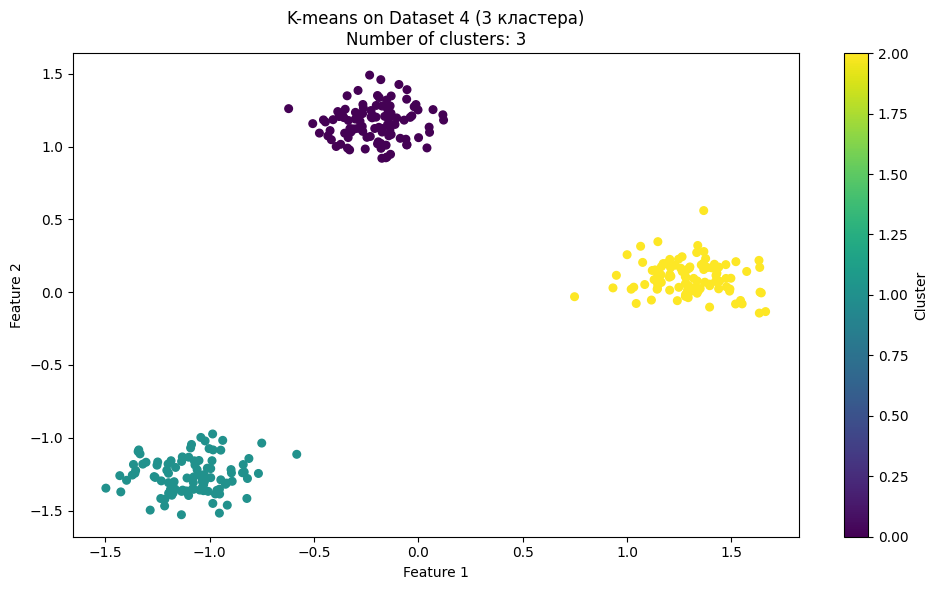


Cluster analysis for Dataset 4 (3 кластера) (K-means):

Cluster sizes:
cluster
0    100
1    100
2    100
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -0.209982   1.164474         0.0
1        -1.090118  -1.262124         2.0
2         1.300100   0.097651         1.0

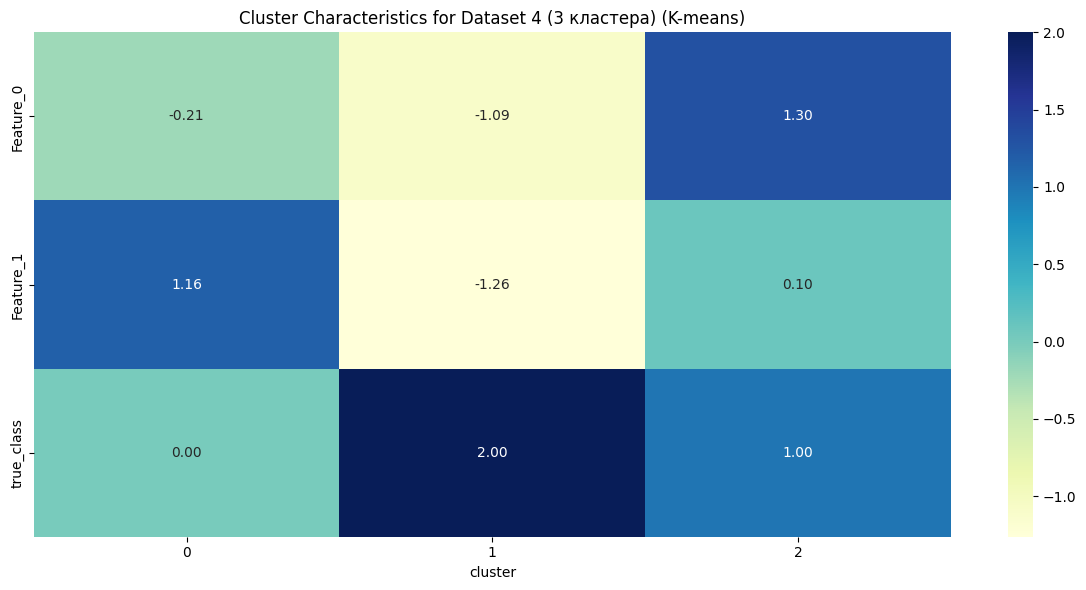


Analyzing DBSCAN results:


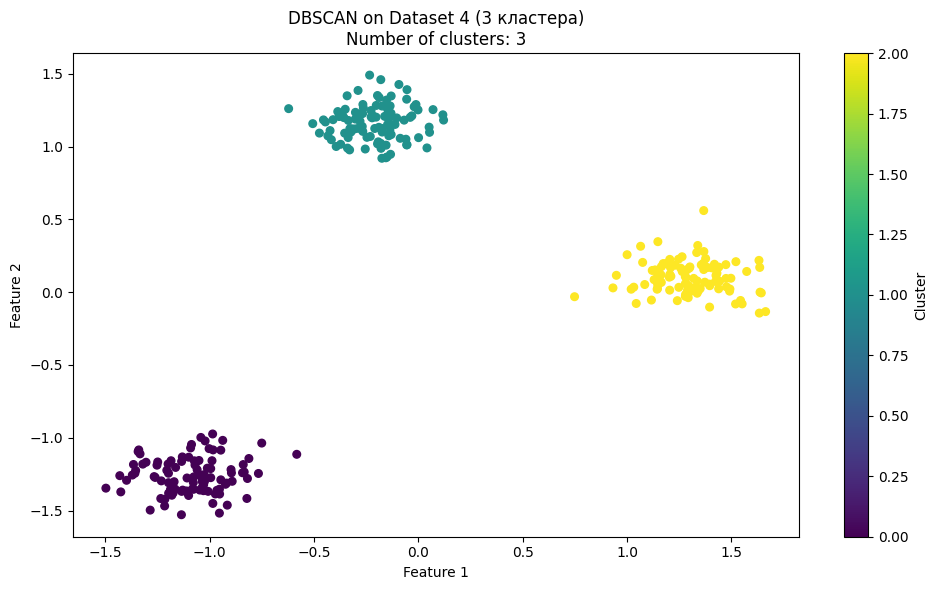


Cluster analysis for Dataset 4 (3 кластера) (DBSCAN):

Cluster sizes:
cluster
0    100
1    100
2    100
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -1.090118  -1.262124         2.0
1        -0.209982   1.164474         0.0
2         1.300100   0.097651         1.0

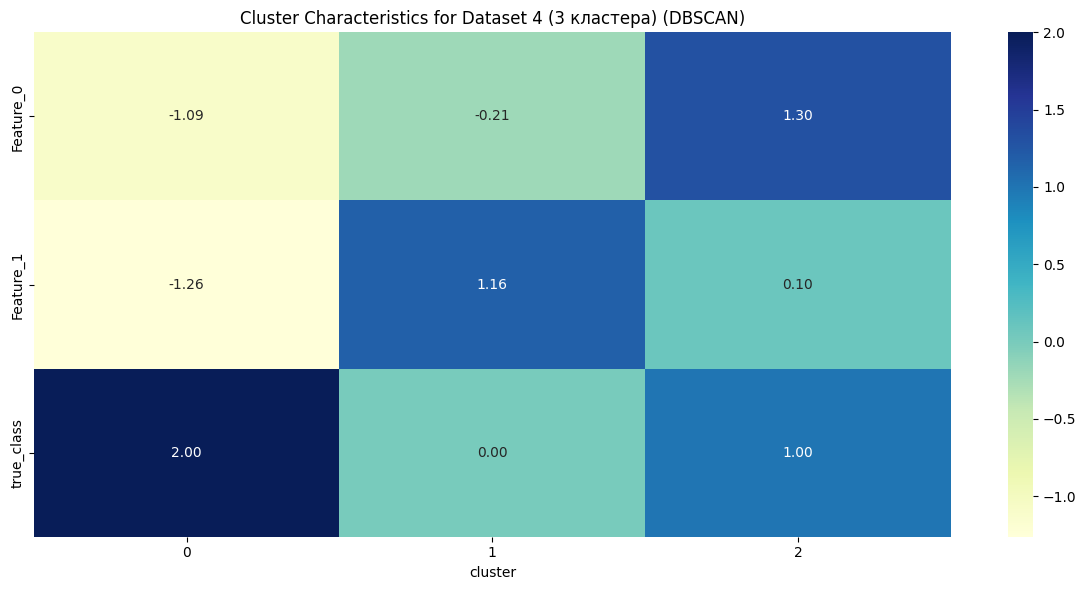


Analyzing GMM results:


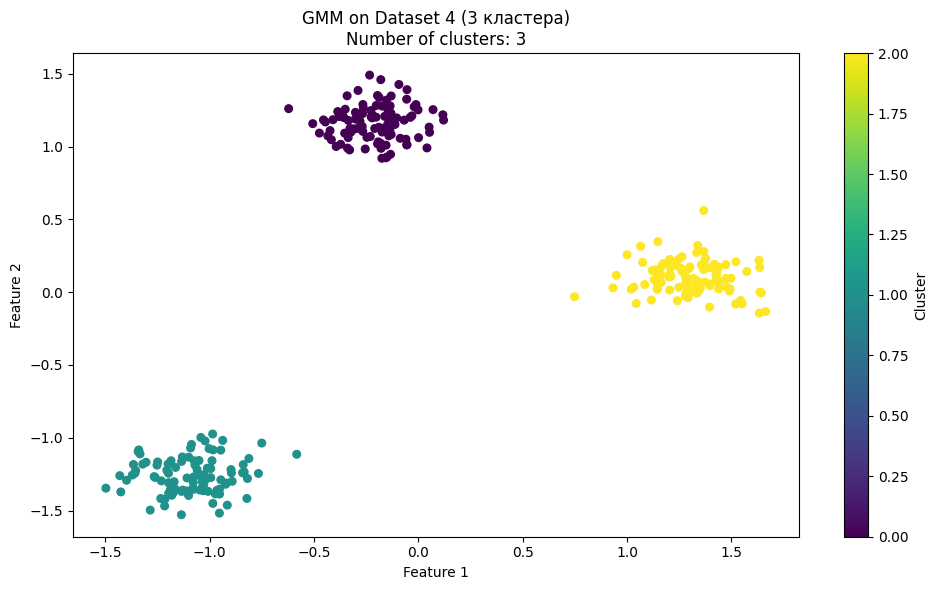


Cluster analysis for Dataset 4 (3 кластера) (GMM):

Cluster sizes:
cluster
0    100
1    100
2    100
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -0.209982   1.164474         0.0
1        -1.090118  -1.262124         2.0
2         1.300100   0.097651         1.0

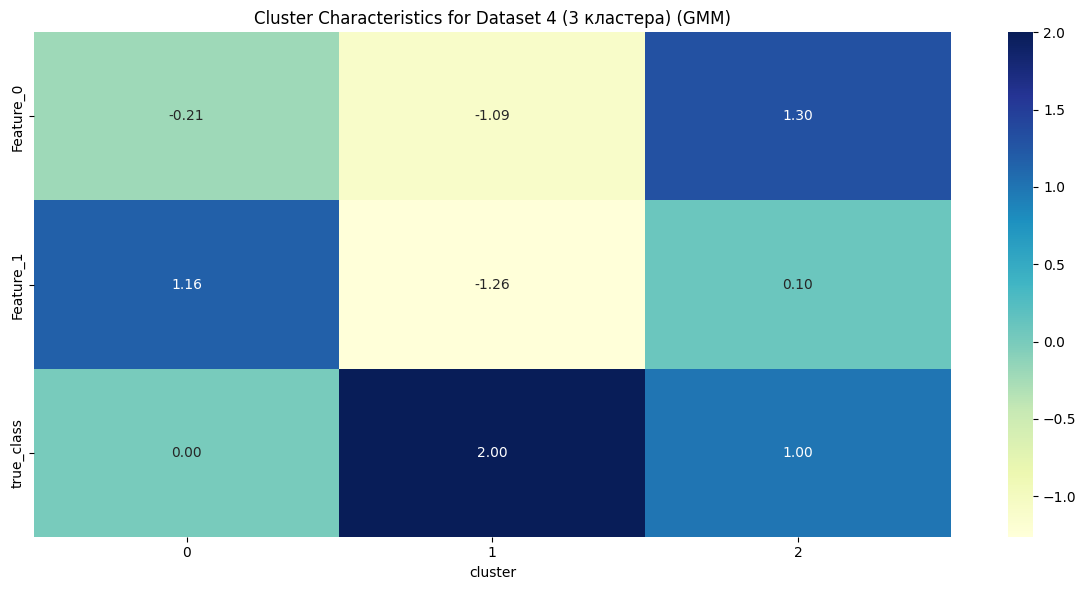


Analyzing AffinityProp results:


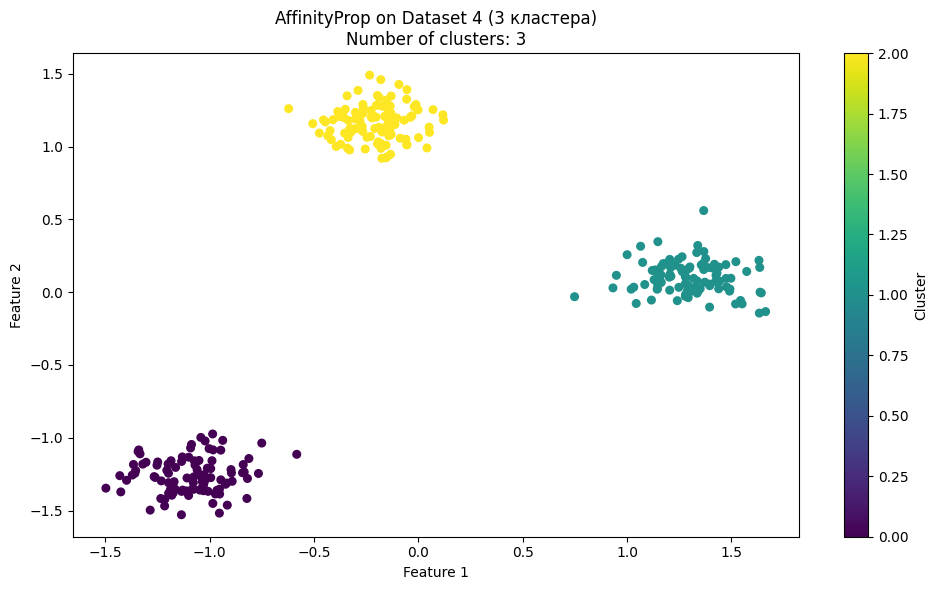


Cluster analysis for Dataset 4 (3 кластера) (AffinityProp):

Cluster sizes:
cluster
0    100
1    100
2    100
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0        -1.090118  -1.262124         2.0
1         1.300100   0.097651         1.0
2        -0.209982   1.164474         0.0

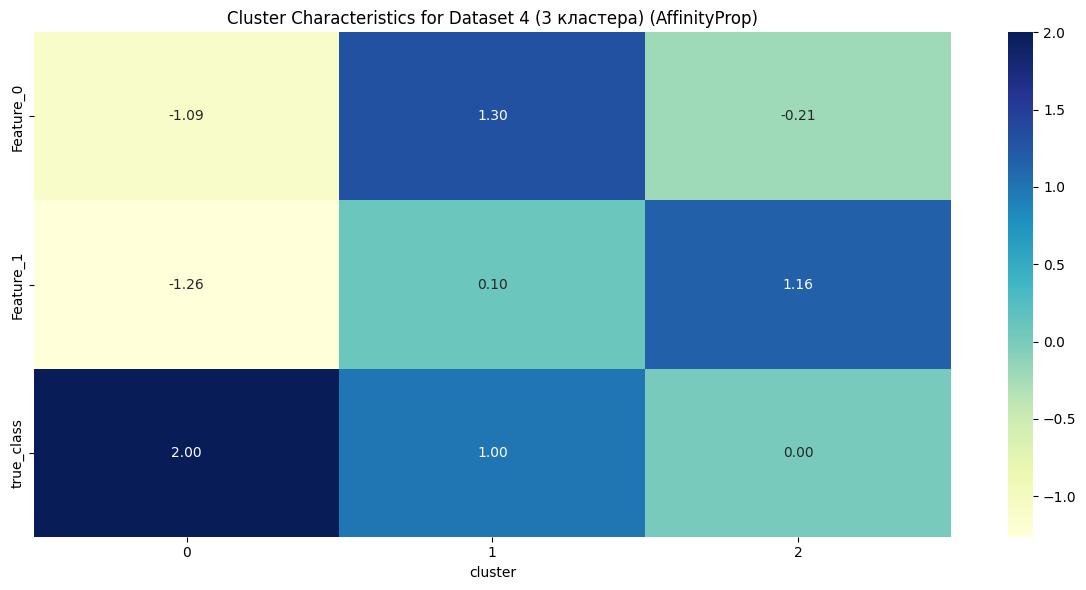


Analyzing Hierarchical results:


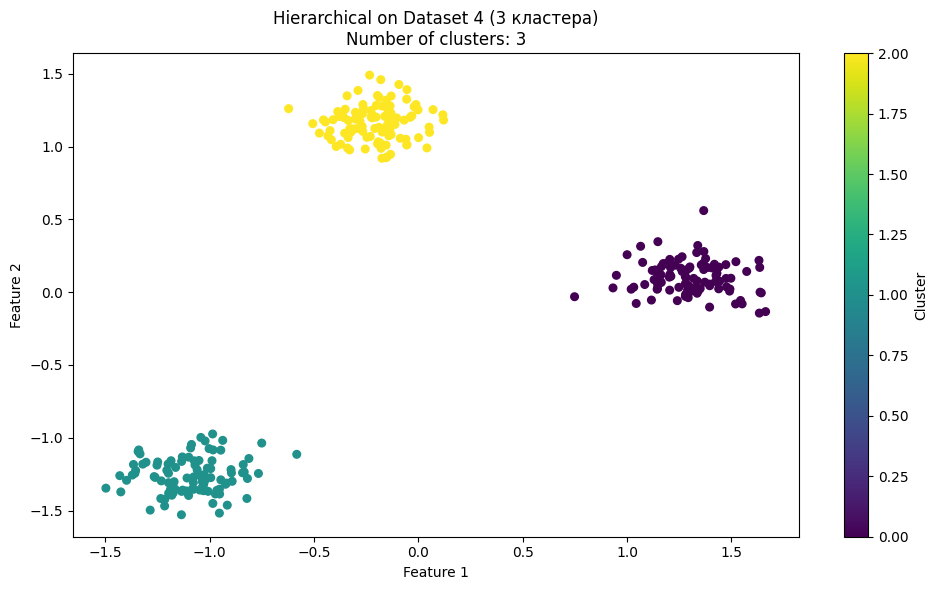


Cluster analysis for Dataset 4 (3 кластера) (Hierarchical):

Cluster sizes:
cluster
0    100
1    100
2    100
Name: count, dtype: int64

Cluster characteristics:


Feature_0  Feature_1  true_class
cluster                                  
0         1.300100   0.097651         1.0
1        -1.090118  -1.262124         2.0
2        -0.209982   1.164474         0.0

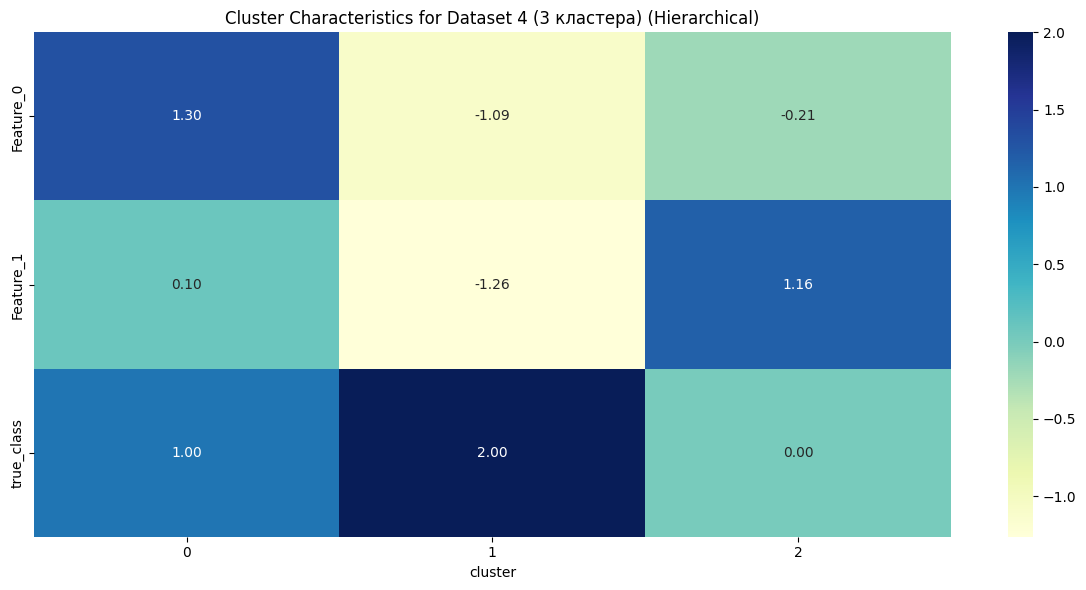



=== Clustering on Dataset 5 (5 кластеров) ===


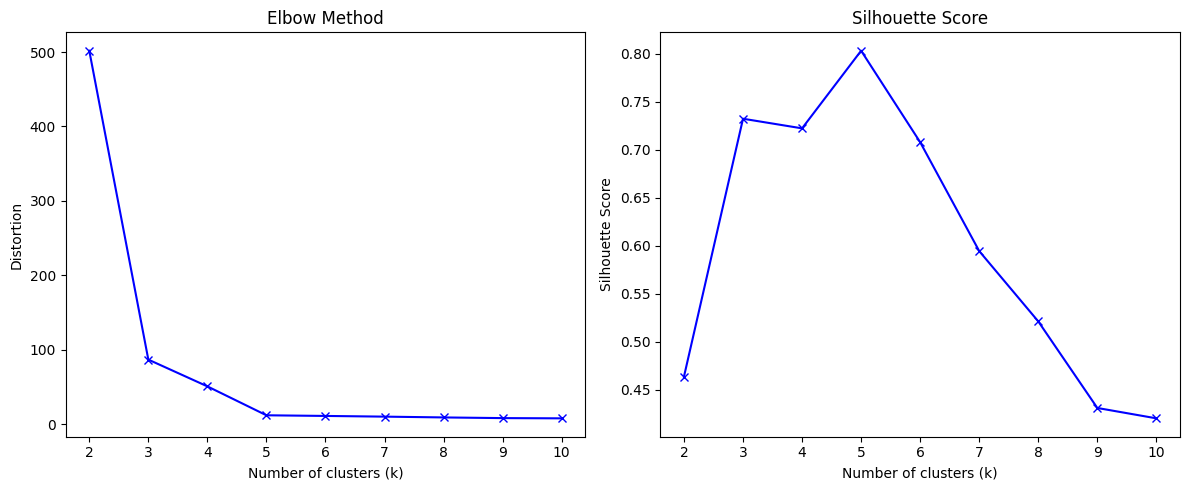

Optimal DBSCAN params: {'eps': 0.2, 'min_samples': 5} (silhouette: 0.795)
Optimal GMM components: 5 (silhouette: 0.803)
Optimal damping: 0.5 (silhouette: 0.803)


In [ ]:
# Основной блок выполнения

def main():
    # Кластеризация на синтетических данных
    synthetic_datasets = generate_synthetic_data()
    for X, y_true, name in synthetic_datasets:
        print(f"\n\n=== Clustering on {name} ===")
        X_scaled = StandardScaler().fit_transform(X)
        
        # Применяем алгоритмы с автоматическим подбором параметров
        results = {}
        
        # K-means
        optimal_k = find_optimal_k(X_scaled)
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        results['K-means'] = kmeans.fit_predict(X_scaled)
        
        # DBSCAN
        dbscan_params = optimize_dbscan(X_scaled)
        dbscan = DBSCAN(**dbscan_params)
        results['DBSCAN'] = dbscan.fit_predict(X_scaled)
        
        # GMM
        optimal_components = optimize_gmm(X_scaled)
        gmm = GaussianMixture(n_components=optimal_components, random_state=42)
        results['GMM'] = gmm.fit_predict(X_scaled)
        
        # Affinity Propagation
        optimal_damping = optimize_affinity_propagation(X_scaled)
        af = AffinityPropagation(damping=optimal_damping, random_state=42)
        results['AffinityProp'] = af.fit_predict(X_scaled)
        
        # Иерархическая кластеризация
        optimal_hierarchical = optimize_hierarchical(X_scaled)
        agg = AgglomerativeClustering(n_clusters=optimal_hierarchical)
        results['Hierarchical'] = agg.fit_predict(X_scaled)
        
        # Визуализация и анализ
        df = pd.DataFrame(X_scaled, columns=[f'Feature_{i}' for i in range(X_scaled.shape[1])])
        df['true_class'] = y_true
        
        for algo_name, labels in results.items():
            print(f"\nAnalyzing {algo_name} results:")
            plot_clusters(X_scaled, labels, f"{algo_name} on {name}", y_true, X_scaled.shape[1]>2)
            df_clustered = analyze_clusters(df.copy(), labels, f"{name} ({algo_name})")
    
    # Кластеризация на данных для классификации
    X_class, y_class, X_pca = load_classification_data()
    print("\n\n=== Clustering on Classification Dataset ===")
    
    # Уменьшаем данные для ускорения обработки
    sample_size = 5000
    if len(X_class) > sample_size:
        idx = resample(np.arange(len(X_class)), 
                      n_samples=sample_size, 
                      stratify=y_class, 
                      random_state=42)
        X_class = X_class[idx]
        y_class = y_class[idx]
        X_pca = X_pca[idx]
    
    # Применяем алгоритмы с автоматическим подбором параметров
    classification_results = {}
    
    # K-means
    optimal_k = find_optimal_k(X_class)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    classification_results['K-means'] = kmeans.fit_predict(X_class)
    
    # DBSCAN
    dbscan_params = optimize_dbscan(X_class)
    dbscan = DBSCAN(**dbscan_params)
    classification_results['DBSCAN'] = dbscan.fit_predict(X_class)
    
    # GMM
    optimal_components = optimize_gmm(X_class)
    gmm = GaussianMixture(n_components=optimal_components, random_state=42)
    classification_results['GMM'] = gmm.fit_predict(X_class)
    
    # Affinity Propagation
    optimal_damping = optimize_affinity_propagation(X_class)
    af = AffinityPropagation(damping=optimal_damping, random_state=42, max_iter=200)
    classification_results['AffinityProp'] = af.fit_predict(X_class)
    
    # Визуализация и анализ
    df_class = pd.DataFrame(X_class, columns=[f'Feature_{i}' for i in range(X_class.shape[1])])
    df_class['true_class'] = y_class
    
    for algo_name, labels in classification_results.items():
        print(f"\nAnalyzing {algo_name} results:")
        plot_clusters(X_pca, labels, f"{algo_name} on Classification Data", y_class)
        analyze_clusters(df_class.copy(), labels, f"Classification Data ({algo_name})")

if __name__ == "__main__":
    main()